## Preliminaries

In [1]:
!pip install matplotlib==3.5.1
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 53.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 129.0 MB/s eta 0:00:01tcmalloc: large alloc 1982242816 bytes == 0x2274000 @  0x7f94f753a1e7 0x4d30a0 0x4d312c 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2
tcmalloc: large alloc 2477809664 bytes == 0x784de000 @  0x7f94f753b615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 139.1 MB/s eta 

In [2]:
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
from datetime import datetime
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set()
print(matplotlib.__version__)

# Import local packages.
path = "/content/drive/MyDrive/Projects"

sys.path.append(f'{path}/quantus')
#import quantus

sys.path.append(f'{path}/MetaQuantus')
import metaquantus
from metaquantus.utils import *
from metaquantus.models import *
from metaquantus.configs import *

#%load_ext autoreload
#%autoreload 2 

import gc
import uuid

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Mounted at /content/drive
3.2.2


ModuleNotFoundError: ignored

In [ ]:
path_results = "/content/drive/MyDrive/Projects/MetaQuantus/results/"

##########################
# Experimental settings. #
##########################

datasets = ["cMNIST", "MNIST", "fMNIST", "ImageNet"]
categories = ['Complexity', 'Localisation', 'Randomisation', 'Faithfulness', 'Robustness']
xai_methods = ['Gradient', 'Saliency', 'GradCAM', 'IntegratedGradients']
models = {"MNIST": "LeNet", "fMNIST": "LeNet", "cMNIST": "ResNet9", "ImageNet": "ResNet18"}

########################
# Estimators, metrics. #
########################

estimators = { "Complexity": ["Sparseness", "Complexity"], "Faithfulness": ["Faithfulness Correlation", "Pixel-Flipping"], "Localisation": ["Pointing-Game", "Relevance Mass Accuracy"], "Randomisation": ["Random Logit", "Model Parameter Randomisation Test"], "Robustness": ["Max-Sensitivity", "Local Lipschitz Estimate"], }
metrics = ['Sparseness', 'Complexity', 'Faithfulness Correlation', 'Pixel-Flipping', 'Pointing-Game', 'Relevance Mass Accuracy', 'Random Logit', 'Model Parameter Randomisation Test', 'Max-Sensitivity', 'Local Lipschitz Estimate']

#############################
# PerturbationTestBase suites, results. #
#############################
results = ['intra_scores', 'inter_scores', 'eval_scores', 'eval_scores_perturbed', 'indices_perturbed']
analyser_suite = ["Model Resilience Test", "Input Resilience Test",  "Model Adversary Test", "Input Adversary Test"]

### Compare s_batch sizes

In [ ]:
dataset_name = "cMNIST"
PATH_ASSETS = "/content/drive/MyDrive/Projects/assets/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
SETTINGS, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_settings = {dataset_name: SETTINGS[dataset_name]}

model = dataset_settings[dataset_name]["models"]["ResNet9"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]
sizes = np.array([np.mean(s_batch[i]) for i in range(len(s_batch))])
sizes.max(), sizes.min(), sizes.mean(), sizes.std()

In [ ]:
dataset_name = "MNIST"
PATH_ASSETS = "/content/drive/MyDrive/Projects/assets/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
SETTINGS, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_settings = {dataset_name: SETTINGS[dataset_name]}

model = dataset_settings[dataset_name]["models"]["LeNet"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]
sizes = np.array([np.mean(s_batch[i]) for i in range(len(s_batch))])
sizes.max(), sizes.min(), sizes.mean(), sizes.std()

In [ ]:
dataset_name = "MNIST"
PATH_ASSETS = "/content/drive/MyDrive/Projects/assets/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
SETTINGS, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_settings = {dataset_name: SETTINGS[dataset_name]}

model = dataset_settings[dataset_name]["models"]["LeNet"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]
sizes = np.array([np.mean(s_batch[i]) for i in range(len(s_batch))])
sizes.max(), sizes.min(), sizes.mean(), sizes.std(), np.median(sizes)

### Plotting configs

In [ ]:
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatches = ['//', '\\\\', '||', '--', '++', 'xx', 'oo', 'OO', '..', '**'] 
hatches = ['/o', '\\|', '|*', '-\\', '+o', 'x*', 'o-', 'O|', 'O.', '*-']

In [ ]:
sns.axes_style()

In [ ]:
"""
data = resource_cmnist["Model Parameter Randomisation Test"]

with sns.axes_style("whitegrid"), sns.plotting_context("notebook", font_scale=1.5):

    
    sns.set_style({'font.family': 'serif', 'font.sans-serif': 'sans-serif'})

    fig, ax = plt.subplots(1,2, figsize=(10,4))
    scores = np.array(list(data["results_"]["Model Adversary Test"]["Gradient"].values())) 
    sns.distplot(scores[:, 0, :], color="green", label="${NORMAL}$", ax=ax[0])
    a = sns.distplot(scores[:, 1, :], color="red", label="${NORMAL}$", ax=ax[0])
    
    a_xticks = np.linspace(scores.min(), scores.max(), 4).round(2)
    
    scores = np.array(list(data["results_"]["Model Adversary Test"]["GradCAM"].values())) 
    sns.distplot(scores[:, 0, :], color="green", label="${NORMAL}$", ax=ax[1])
    b = sns.distplot(scores[:, 1, :], color="red", label="${RAN}$", ax=ax[1])
    
    b_xticks = np.linspace(scores.min(), scores.max(), 4).round(2)
    
    ax[0].title.set_text('Gradient')
    ax[1].title.set_text('GradCAM')

    a.set(yticklabels=[])  
    b.set(yticklabels=[]) 

    #a.set(xticklabels=a_xticks)  #ax[1].set_xticklabels([])
    #b.set(xticklabels=b_xticks)    
    
    a.set(ylabel=None)
    b.set(ylabel=None)
    
    #a.set(title='Penguins: Body Mass by Species for Gender')
    #plt.legend()
    
    fig.show()
""";

In [ ]:
cnames = {
'aliceblue':            '#F0F8FF',
'antiquewhite':         '#FAEBD7',
'aqua':                 '#00FFFF',
'aquamarine':           '#7FFFD4',
'azure':                '#F0FFFF',
'beige':                '#F5F5DC',
'bisque':               '#FFE4C4',
'black':                '#000000',
'blanchedalmond':       '#FFEBCD',
'blue':                 '#0000FF',
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chartreuse':           '#7FFF00',
'chocolate':            '#D2691E',
'coral':                '#FF7F50',
'cornflowerblue':       '#6495ED',
'cornsilk':             '#FFF8DC',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkgoldenrod':        '#B8860B',
'darkgray':             '#A9A9A9',
'darkgreen':            '#006400',
'darkkhaki':            '#BDB76B',
'darkmagenta':          '#8B008B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darkorchid':           '#9932CC',
'darkred':              '#8B0000',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'goldenrod':            '#DAA520',
'gray':                 '#808080',
'green':                '#008000',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'lavender':             '#E6E6FA',
'lavenderblush':        '#FFF0F5',
'lawngreen':            '#7CFC00',
'lemonchiffon':         '#FFFACD',
'lightblue':            '#ADD8E6',
'lightcoral':           '#F08080',
'lightcyan':            '#E0FFFF',
'lightgoldenrodyellow': '#FAFAD2',
'lightgreen':           '#90EE90',
'lightgray':            '#D3D3D3',
'lightpink':            '#FFB6C1',
'lightsalmon':          '#FFA07A',
'lightseagreen':        '#20B2AA',
'lightskyblue':         '#87CEFA',
'lightslategray':       '#778899',
'lightsteelblue':       '#B0C4DE',
'lightyellow':          '#FFFFE0',
'lime':                 '#00FF00',
'limegreen':            '#32CD32',
'linen':                '#FAF0E6',
'magenta':              '#FF00FF',
'maroon':               '#800000',
'mediumaquamarine':     '#66CDAA',
'mediumblue':           '#0000CD',
'mediumorchid':         '#BA55D3',
'mediumpurple':         '#9370DB',
'mediumseagreen':       '#3CB371',
'mediumslateblue':      '#7B68EE',
'mediumspringgreen':    '#00FA9A',
'mediumturquoise':      '#48D1CC',
'mediumvioletred':      '#C71585',
'midnightblue':         '#191970',
'mintcream':            '#F5FFFA',
'mistyrose':            '#FFE4E1',
'moccasin':             '#FFE4B5',
'navajowhite':          '#FFDEAD',
'navy':                 '#000080',
'oldlace':              '#FDF5E6',
'olive':                '#808000',
'olivedrab':            '#6B8E23',
'orange':               '#FFA500',
'orangered':            '#FF4500',
'orchid':               '#DA70D6',
'palegoldenrod':        '#EEE8AA',
'palegreen':            '#98FB98',
'paleturquoise':        '#AFEEEE',
'palevioletred':        '#DB7093',
'papayawhip':           '#FFEFD5',
'peachpuff':            '#FFDAB9',
'peru':                 '#CD853F',
'pink':                 '#FFC0CB',
'plum':                 '#DDA0DD',
'powderblue':           '#B0E0E6',
'purple':               '#800080',
'red':                  '#FF0000',
'rosybrown':            '#BC8F8F',
'royalblue':            '#4169E1',
'saddlebrown':          '#8B4513',
'salmon':               '#FA8072',
'sandybrown':           '#FAA460',
'seagreen':             '#2E8B57',
'seashell':             '#FFF5EE',
'sienna':               '#A0522D',
'silver':               '#C0C0C0',
'skyblue':              '#87CEEB',
'slateblue':            '#6A5ACD',
'slategray':            '#708090',
'snow':                 '#FFFAFA',
'springgreen':          '#00FF7F',
'steelblue':            '#4682B4',
'tan':                  '#D2B48C',
'teal':                 '#008080',
'thistle':              '#D8BFD8',
'tomato':               '#FF6347',
'turquoise':            '#40E0D0',
'violet':               '#EE82EE',
'wheat':                '#F5DEB3',
'white':                '#FFFFFF',
'whitesmoke':           '#F5F5F5',
'yellow':               '#FFFF00',
'yellowgreen':          '#9ACD32'}

In [ ]:
# Colours.
X_gt = [-1, 0, 1, 0]
Y_gt = [0, 1, 0, -1]
for c, v in cnames.items():
    plt.figure(figsize=(1,1))
    plt.fill(X_gt, Y_gt, color=c)#, alpha=0.5)
    plt.title(c)
    plt.show()

NameError: ignored

In [ ]:
colours_categories = {'Complexity': "brown", 'Faithfulness': "blue", 'Localisation': "orange", 'Randomisation': "green", 'Robustness': "red"}
colours = {'Sparseness': "#411900", 
 'Complexity': "#7f4e1e",
 'Faithfulness Correlation': "#00555a",
 'Pixel-Flipping': "cadetblue",
 'Pointing-Game': "chocolate",
 'Relevance Mass Accuracy': "peru",
 'Random Logit': "darkolivegreen",
 'Model Parameter Randomisation Test': "darkseagreen",
 'Max-Sensitivity': "darkred",
 'Local Lipschitz Estimate': "indianred",}
 
plt.style.use(['seaborn-white'])

## Analyse a motivating example

In [ ]:
# Get benchmarking data.
path = Path(path_results+"example/")    
sorted([str(f.stem) for f in list(path.iterdir())])

In [ ]:
dataset_name = "cMNIST"
category="Faithfulness"
ranking_results = load_obj(path_results+"example/", fname=f"21122022_faithfulness_ranking_exercise_122c", use_json=True)#[dataset_name]["ResNet9"]
ranking_df = pd.read_csv(path_results+"example/"+"21122022_faithfulness_df_122c"+".csv", index_col=0)
ranking_results.keys()
ranking_df

,Estimator,Method,Faithfulness Score,Rank
0,Faithfulness Correlation,IntegratedGradients,0.175225,1.0
1,Faithfulness Correlation,Gradient,0.000894,3.0
2,Faithfulness Correlation,GradCAM,0.150308,2.0
3,Pixel-Flipping,IntegratedGradients,3.433365,2.0
4,Pixel-Flipping,Gradient,2.854514,1.0
5,Pixel-Flipping,GradCAM,5.121380,3.0


In [ ]:
ranking_df.groupby("Method")["Rank"].mean()

Method
GradCAM                2.5
Gradient               2.0
IntegratedGradients    1.5
Name: Rank, dtype: float64

In [ ]:
benchmark_cmnist = load_obj(path_results+"benchmarks/", fname=f"14122022_cMNIST_benchmark_exercise_ef2c_f", use_json=True)[dataset_name]["ResNet9"]

def make_dataset_example(benchmark: dict,
                         estimators: dict):
    df = pd.DataFrame(columns=["Category", "Estimator", "Test", "IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}", "MC", "IAC_{NR} std", "IAC_{AR} std", "IEC_{NR} std", "IEC_{AR} std", "MC std"])
    scores = ["IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}"]

    row= 0
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            for px, perturbation_type in enumerate(["Model", "Input"]):

                if estimator_category in benchmark:
                    if estimator_name in benchmark[estimator_category]:
                        row += ex1+ex2+px
                        df.loc[row, "Test"] = perturbation_type
                        df.loc[row, "Category"] = estimator_category
                        df.loc[row, "Estimator"] = estimator_name
                        
                        for s in scores:
                            score = np.array(benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["consistency_scores"][s])
                            df.loc[row, s] = score.mean()
                            df.loc[row, s+" std"] = score.std()*2

                        df.loc[row, "MC"] = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                        df.loc[row, "MC std"] = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]*2

    return df

summary_df = make_dataset_example(benchmark=benchmark_cmnist, estimators={"Faithfulness": estimators["Faithfulness"]})
summary_df

,Category,Estimator,Test,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR},MC,IAC_{NR} std,IAC_{AR} std,IEC_{NR} std,IEC_{AR} std,MC std
0,Faithfulness,Faithfulness Correlation,Model,0.508274,0.938654,0.182307,0.621597,0.562708,0.060783,0.01707,0.004055,0.004533,0.017106
1,Faithfulness,Faithfulness Correlation,Input,0.490366,0.934464,0.187847,0.634234,0.561728,0.030999,0.018001,0.008042,0.011727,0.009958
2,Faithfulness,Pixel-Flipping,Model,0.564806,0.965365,0.286675,0.526238,0.585771,0.040379,0.021884,0.005346,0.079605,0.021725
4,Faithfulness,Pixel-Flipping,Input,0.495005,0.99476,0.294878,0.700979,0.621406,0.037459,0.001208,0.012182,0.002161,0.009956


In [ ]:
summary_df.groupby("Estimator")["MC"].mean()

Estimator
Faithfulness Correlation    0.562218
Pixel-Flipping              0.603588
Name: MC, dtype: float64

In [ ]:
dataset_name = "cMNIST"
PATH_ASSETS = "/content/drive/MyDrive/Projects/assets/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get input, outputs settings.
SETTINGS, model_name = setup_dataset_models(
    dataset_name=dataset_name, path_assets=PATH_ASSETS, device=device
)
dataset_settings = {dataset_name: SETTINGS[dataset_name]}
dataset_kwargs = dataset_settings[dataset_name]["estimator_kwargs"]

model = dataset_settings[dataset_name]["models"]["ResNet9"].eval()
x_batch = dataset_settings[dataset_name]["x_batch"]
y_batch = dataset_settings[dataset_name]["y_batch"]
s_batch = dataset_settings[dataset_name]["s_batch"]

In [ ]:
from metaquantus.configs import setup_estimators, setup_xai_settings

# Get estimators.
estimators = setup_estimators(
    features=dataset_kwargs["features"],
    num_classes=dataset_kwargs["num_classes"],
    img_size=dataset_kwargs["img_size"],
    percentage=dataset_kwargs["percentage"],
    patch_size=dataset_kwargs["patch_size"],
    perturb_baseline=dataset_kwargs["perturb_baseline"],
)

# Get explanation methods.
xai_setting = ["Gradient", "GradCAM", "GradientShap", "Saliency", "IntegratedGradients", "InputXGradient"]
xai_methods = setup_xai_settings(
    xai_settings=xai_setting,
    gc_layer=dataset_settings[dataset_name]["gc_layers"][model_name],
    img_size=dataset_kwargs["img_size"],
    nr_channels=dataset_kwargs["nr_channels"],
)

An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.
An absolute operation should be applied on the attributions, otherwise inconsistent results can be expected. Re-set 'abs' parameter.


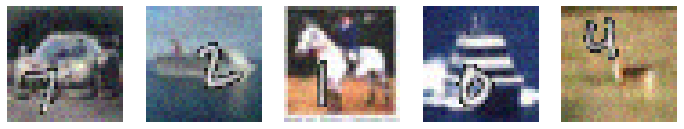

In [ ]:
fix, ax = plt.subplots(1, 5, figsize=(12, 4))

for i in range(5): 
    ax[i].imshow(np.moveaxis(x_batch[i], 0, -1).reshape(32,32, 3))
    ax[i].axis("off")
plt.show()

In [ ]:
# Generate explanations.
explanations = {}
for method, kwargs in xai_methods.items():
    if method in ranking_results.keys():
        model = dataset_settings[dataset_name]["models"]["ResNet9"].eval().cpu()
        explanations[method] = quantus.explain(model=model, inputs=x_batch[:5], targets=y_batch[:5], **{**{"method": method}, **kwargs})

  FC (↑): 0.001 (R=3)
  PF (↓): 2.855 (R=1)
  FC (↑): 0.150 (R=2)
  PF (↓): 5.121 (R=3)
  FC (↑): 0.175 (R=1)
  PF (↓): 3.433 (R=2)


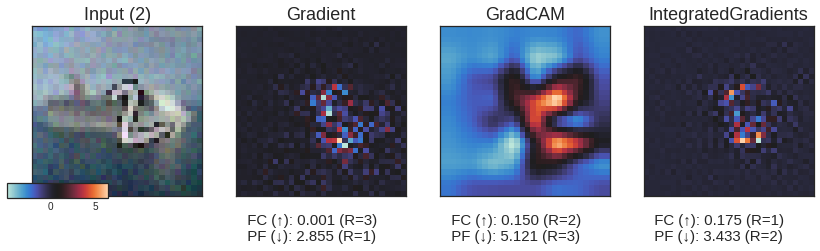

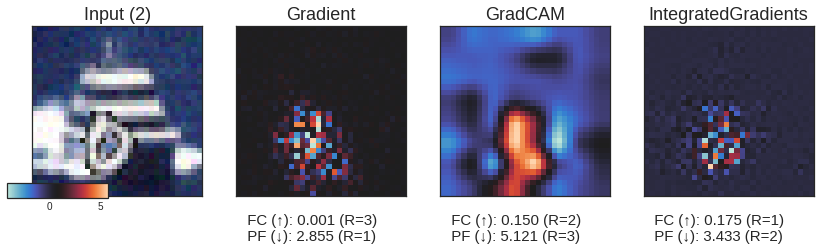

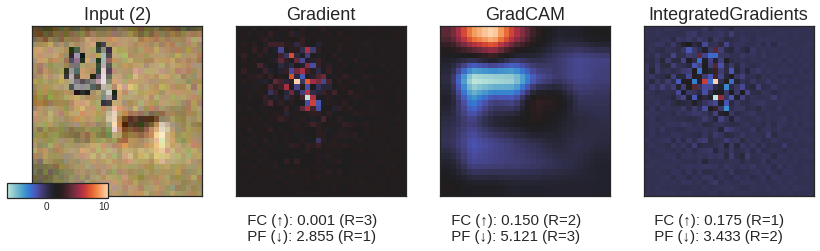

In [ ]:
# Plot!
for index in [1,3,4]:

    fig, ax = plt.subplots(1, 1+len(explanations), figsize=(14, 4))
    for i, (method, values) in enumerate(explanations.items()): 
        
        fc = np.mean(ranking_results[method]["Faithfulness Correlation"]["scores_norm"])
        fc_rank = int(ranking_df.loc[(ranking_df["Method"]==method) & (ranking_df["Estimator"]=="Faithfulness Correlation"), "Rank"].values[0])
        pf = np.mean(ranking_results[method]["Pixel-Flipping"]["scores_norm"])
        pf_rank = int(ranking_df.loc[(ranking_df["Method"]==method) & (ranking_df["Estimator"]=="Pixel-Flipping"), "Rank"].values[0])
        text = f"  FC (↑): {fc:.3f} (R={fc_rank})\n  PF (↓): {pf:.3f} (R={pf_rank})"
        
        if index == 1:
            print(text)
        
        ax[i+1].set_xticks([], [])
        ax[i+1].set_yticks([], [])
        ax[i+1].set_title(method, fontsize=18)
        axis = ax[i+1].imshow((explanations[method][index].reshape(32,32)), cmap="icefire")
        #axis = ax[i+1].imshow(quantus.normalise_func.normalise_by_max(explanations[method][index].reshape(32,32)), cmap="icefire")
        
        ax[i+1].text(0, 40, text, fontsize=15)
        

    ax[0].imshow(np.moveaxis(x_batch[index], 0, -1).reshape(32,32, 3))
    ax[0].set_xticks([], [])
    ax[0].set_yticks([], [])
    ax[0].set_title("Input (2)", fontsize=18)

    cax = fig.add_axes([0.1, 0.2, 0.1, 0.05]) # cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
    fig.colorbar(axis, cax=cax, orientation='horizontal')
    plt.savefig(path_results+"plots/"+f"motivating_example_{dataset_name}_{index}.png", dpi=1000)
    plt.show()


In [ ]:
def plot_random(explanations, x_batch, title=""):
    fig, ax = plt.subplots(1, 1+len(explanations), figsize=(14, 4))
    index = 0
    ax[0].imshow(np.moveaxis(x_batch[index], 0, -1).reshape(32, 32, 3), cmap="gray")
    for i, (method, values) in enumerate(explanations.items()): 
        axis = ax[i+1].imshow((explanations[method][index].reshape(32,32)), cmap="icefire")
    fig.suptitle(title)

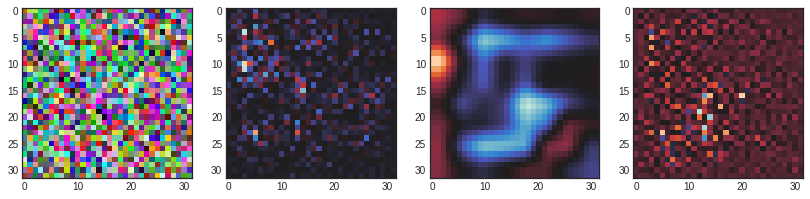

In [ ]:
# Generate explanations from random input.

def generate_random_explanation(model, inputs, targets, **kwargs):
    random_explanations = np.random.uniform(
    low=inputs.min(),
    high=inputs.max(),
    size=inputs.shape,
    )
    return random_explanations

uniform_sampled_input = generate_random_explanation(model=model, inputs=x_batch, targets=y_batch)
explanations_random = {}
for method, kwargs in xai_methods.items():
    if method in ranking_results.keys():
        model = dataset_settings[dataset_name]["models"]["ResNet9"].eval().cpu()
        explanations_random[method] = quantus.explain(model=model, inputs=uniform_sampled_input[:50], targets=y_batch[:50], **{**{"method": method}, **kwargs})


plot_random(explanations=explanations_random, x_batch=uniform_sampled_input)

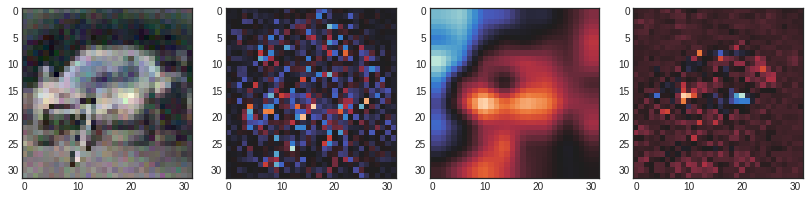

In [ ]:
from copy import deepcopy
import torch

# Generate explanations from random model.

def generate_random_explanation(model, loc=1.0, scale=2.0):
    distribution = torch.distributions.normal.Normal(loc=loc, scale=scale)
    random_model = deepcopy(model)
    random_model.load_state_dict(model.state_dict())
    with torch.no_grad():
        for layer in random_model.parameters():
            layer.mul_(distribution.sample(layer.size()).to(layer.device))
    return random_model

explanations_random_model = {}
for method, kwargs in xai_methods.items():
    if method in ranking_results.keys():
        random_model = generate_random_explanation(model=model).eval().cpu()
        explanations_random_model[method] = quantus.explain(model=random_model, inputs=x_batch[:50], targets=y_batch[:50], **{**{"method": method}, **kwargs})

plot_random(explanations=explanations_random_model, x_batch=x_batch)

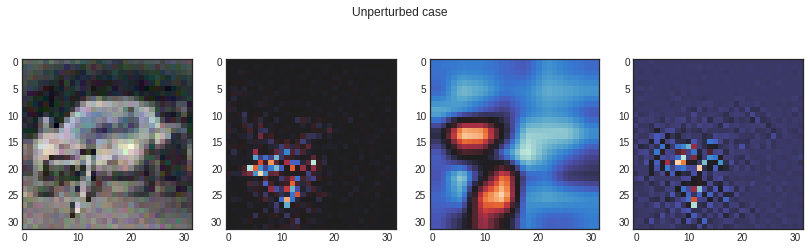

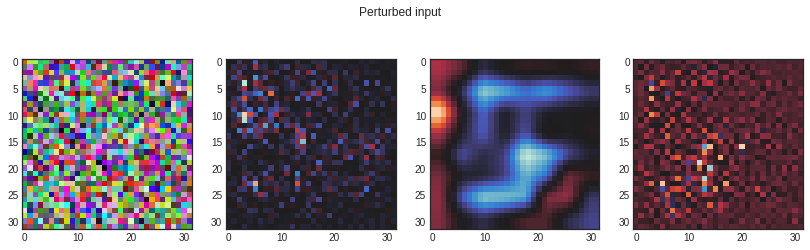

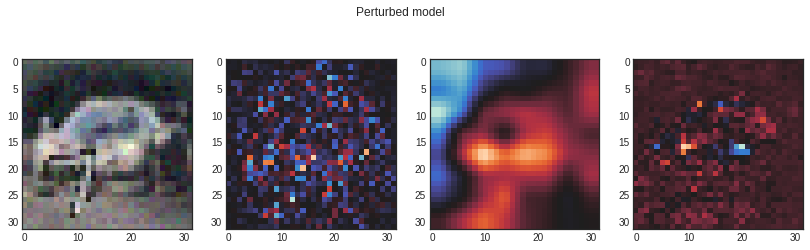

In [ ]:
plot_random(explanations=explanations, x_batch=x_batch, title="Unperturbed case")
plot_random(explanations=explanations_random, x_batch=uniform_sampled_input, title="Perturbed input")
plot_random(explanations=explanations_random_model, x_batch=x_batch, title="Perturbed model")

## Analyse hp results

In [ ]:
# Get hp data.
path = Path(path_results+"hp/")    
[str(f.stem) for f in list(path.iterdir())]

In [ ]:
# Result MNSIT.
#result_hp = {'Test': ['MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT', 'MPT'], 'MC Mean': [0.5944750266111257, 0.6113948031360169, 0.6158474412879695, 0.5979526857566656, 0.619994782400155, 0.6146328481323311, 0.5962773256488019, 0.5427608553785862, 0.5525629574309472, 0.6195483609991637, 0.6018573789474742, 0.5733207951338495], 'MC Std': [0.014152682712831877, 0.012257593331852834, 0.009596690537797381, 0.005341825454632132, 0.0038938414248706477, 0.012218730779052223, 0.012281416258372813, 0.012179118009654544, 0.011795696195353145, 0.012447819180385455, 0.010293211879690178, 0.015208321961645899], 'Baseline Strategy': ['Black', 'Black', 'Black', 'Black', 'Uniform', 'Uniform', 'Uniform', 'Uniform', 'Mean', 'Mean', 'Mean', 'Mean'], 'Subset Size': [28, 52, 102, 128, 28, 52, 102, 128, 28, 52, 102, 128], 'IAC_{NR} mean': [0.48723744061197516, 0.5354164317137856, 0.5626048398253881, 0.5193373068457012, 0.5599899724111659, 0.6004828186750724, 0.49489572766954, 0.32357237044931225, 0.3110645044615371, 0.5683860794463371, 0.5136019593034635, 0.40080206576187205], 'IAC_{NR} std': [0.05050328902605908, 0.04868147792398517, 0.03928051144551925, 0.022556998731233985, 0.012293741706152495, 0.026256955165493423, 0.052530143029203835, 0.028289100568665904, 0.05850510909278442, 0.05024067126585602, 0.04071968514534746, 0.05872278227228589], 'IAC_{AR} mean': [0.9874980144263633, 0.9999437864218983, 0.9974277808027102, 0.9840933879493103, 0.9973625233239835, 0.973565432423579, 0.9998652681102609, 0.9709221361233173, 0.994187487703937, 0.9998100428143228, 0.9994137600425561, 0.9978894366626452], 'IAC_{AR} std': [0.05050328902605908, 0.04868147792398517, 0.03928051144551925, 0.022556998731233985, 0.012293741706152495, 0.026256955165493423, 0.052530143029203835, 0.028289100568665904, 0.05850510909278442, 0.05024067126585602, 0.04071968514534746, 0.05872278227228589], 'IEC_{NR} mean': [0.2624755859375, 0.2632568359375, 0.2637939453125, 0.2627685546875, 0.26865234375, 0.2598876953125, 0.2584228515625, 0.2571044921875, 0.26484375, 0.2645263671875, 0.26423339843750004, 0.2594482421875], 'IEC_{NR} std': [0.0048583984374999944, 0.002026367187499989, 0.003735351562499989, 0.0006103515625, 0.0019042968750000167, 0.005151367187499978, 0.003979492187499989, 0.0024169921874999944, 0.006152343750000011, 0.0014892578124999778, 0.0034423828125000056, 0.0008056640624999889], 'IEC_{AR} mean': [0.6406890654686646, 0.6469621584708836, 0.6395631992112796, 0.6256114935441508, 0.6539742901154708, 0.6245954461181731, 0.6319254552529066, 0.6194444227542153, 0.640156087558315, 0.6454709545484947, 0.6301803980063769, 0.6351434359233807], 'IEC_{AR} std': [0.003030087209693333, 0.002324180025237099, 0.0037990909690557295, 0.004308585873819382, 0.0027933849907574304, 0.0011919612416885217, 0.0005903214500727616, 0.006309573351051645, 0.002141631864087057, 0.000987059873667151, 0.00280630272473803, 0.0009537395527507431]}

# Result ImageNet.
df_result = pd.read_csv(path_results+"hp/"+"02122022_hp_tuning_exercise_e884.csv")

In [ ]:
#df_result = pd.DataFrame.from_dict(result_hp)
df_result["Setting"] = np.arange(1, len(df_result)+1)
df_result.head()

In [ ]:
df_result.loc[df_result["MC Mean"].argmax()]

In [ ]:

def plot_hp_bar(df_result: pd.DataFrame,
            dataset_name: str):

    settings = np.arange(len(df_result))
    mc_scores = df_result['MC Mean'].values
    mc_scores_std = df_result['MC Std'].values
    iac_nr = df_result['IAC_{NR} mean'].values
    iac_ar = df_result['IAC_{AR} mean'].values
    iec_nr = df_result['IEC_{NR} mean'].values
    iec_ar = df_result['IEC_{AR} mean'].values

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    barlist1=ax.bar(settings, iec_nr, alpha=0.65, color='lightgray', label="IEC_NR") ##aaa662
    barlist2=ax.bar(settings, iac_nr, alpha=0.65,  bottom=iec_nr,  color='darkgray', label="IAC_NR") ##719f91
    barlist3=ax.bar(settings, iec_ar, alpha=0.65, bottom=(iac_nr+iec_nr),  color='gray',  label="IEC_AR") ##c87f89
    barlist4=ax.bar(settings, iac_ar, alpha=0.65, bottom=(iec_ar+iac_nr+iec_nr), yerr=mc_scores_std, color='#738595', label="IAC_AR", hatch="") #738595#afa88b

    #plt.plot(2+mc_scores, "-o", c="black")

    for i in settings:
        if mc_scores[i] == mc_scores.max():
            plt.annotate(xy=(i-0.4, 1.7+mc_scores[i]), text=f"{(str(mc_scores[i]))[:5]}", fontsize=20, c="red", weight='bold')
        else:
            plt.annotate(xy=(i-0.4, 1.7+mc_scores[i]), text=f"{(str(mc_scores[i]))[:5]}", fontsize=20, weight='bold')

    ax.bar_label(barlist1, fmt='%.3f', label_type='center', fontsize=18)
    ax.bar_label(barlist2, fmt='%.3f', label_type='center', fontsize=18)
    ax.bar_label(barlist3, fmt='%.3f', label_type='center', fontsize=18)
    ax.bar_label(barlist4, fmt='%.3f', label_type='center', fontsize=18)

    ax.set_yticks([])
    ax.set_xticks(ticks=np.arange(0, len(df_result)), labels=[f"P{i+1}" for i in range(len(df_result))], fontsize=20)
    ax.legend(ncol=4, fontsize=20) # loc=2,
    ax.grid()
    plt.xlabel(" ", fontsize=20)
    plt.ylabel(" ", fontsize=20)

    plt.ylim(0, 2.8)

    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"hp_{dataset_name}.png", dpi=1000)
    plt.show()

In [ ]:
def plot_hp_stacked(df_result: pd.DataFrame,
            dataset_name: str):

    settings = np.arange(len(df_result))
    mc_scores = df_result['MC Mean'].values
    mc_scores_std = df_result['MC Std'].values
    iac_nr = df_result['IAC_{NR} mean'].values
    iac_ar = df_result['IAC_{AR} mean'].values
    iec_nr = df_result['IEC_{NR} mean'].values
    iec_ar = df_result['IEC_{AR} mean'].values

    totals = (iec_nr+iac_nr+iec_ar+iac_ar)
    y1 = (iec_nr)
    y2 = (iec_nr+iac_nr)
    y3 = (iec_nr+iac_nr+iec_ar)
    y4 = (iec_nr+iac_nr+iec_ar+iac_ar)

    c1 = "#d8dcd6" #"#82cbb2"
    c2 = "#929591" #"#cc7a8b"
    c3 = "#7d7f7c" #"#76a973"
    c4 = "#738595" #"#5a86ad"

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    plt.plot(settings, y1, color="black")
    plt.plot(settings, y2, color="black")
    plt.plot(settings, y3, color="black")
    plt.plot(settings, y4, color="black")

    plt.fill_between(settings, y1, 0, color=c1, alpha=0.5, label="IEC_NR", edgecolor="black")
    plt.fill_between(settings, y1, y2, color=c2, alpha=0.5, label="IAC_NR", edgecolor="black")
    plt.fill_between(settings, y2, y3, color=c3, alpha=0.5, label="IEC_AR", edgecolor="black")
    plt.fill_between(settings, y3, y4, color=c4, alpha=0.5, label="IAC_AR", edgecolor="black")

    for i in settings:
        if mc_scores[i] == mc_scores.max():
            plt.annotate(xy=(i-0.4, 1.7+mc_scores[i]), text=f"{(str(mc_scores[i]))[:5]}", fontsize=15, c="red", weight='bold')
        else:
            plt.annotate(xy=(i-0.4, 1.7+mc_scores[i]), text=f"{(str(mc_scores[i]))[:5]}", fontsize=15, weight='bold')

        plt.vlines(x=i, ymin=0, ymax=1.6+mc_scores[i], color="black")
                
    plt.yticks([])
    plt.legend(ncol=4, fontsize=15) 
    plt.xticks(ticks=np.arange(0, len(df_result)), labels=[f"P{i+1}" for i in range(len(df_result))], fontsize=12)
    plt.grid()
    plt.xlabel(" ", fontsize=15)
    plt.ylabel(" ", fontsize=15)
    plt.ylim(0, 2.8)
    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"hp_{dataset_name}.png", dpi=1000)
    plt.show()

In [ ]:
#plot_hp_bar(df_result=df_result, dataset_name="ImageNet")
plot_hp_stacked(df_result=df_result, dataset_name="ImageNet")

## Analyse benchmarking data

In [ ]:
# Get benchmarking data.
path = Path(path_results+"benchmarks/")    
sorted([str(f.stem) for f in list(path.iterdir()) if "benchmark_exercise" in str(f.stem)])

['01122022_MNIST_benchmark_exercise_9fdd',
 '01122022_cMNIST_benchmark_exercise_cdac',
 '01122022_fMNIST_benchmark_exercise_211e',
 '06122022_MNIST_benchmark_exercise_5314_bm',
 '06122022_cMNIST_benchmark_exercise_e72a_bm',
 '06122022_fMNIST_benchmark_exercise_25c1_bm',
 '07122022_MNIST_benchmark_exercise_09d5_Gradient_Saliency_IntegratedGradients_GradientShap_InputXGradient',
 '07122022_MNIST_benchmark_exercise_0db1_Gradient_Saliency',
 '07122022_MNIST_benchmark_exercise_0e6d_Gradient_Saliency_IntegratedGradients_GradientShap_InputXGradient_GradCAM',
 '07122022_MNIST_benchmark_exercise_176c_Gradient_Saliency_IntegratedGradients_GradientShap',
 '07122022_MNIST_benchmark_exercise_1df0_Gradient_Saliency',
 '07122022_MNIST_benchmark_exercise_48e5_Gradient_Occlusion',
 '07122022_MNIST_benchmark_exercise_59f1_Gradient_InputXGradient',
 '07122022_MNIST_benchmark_exercise_6b45_Gradient_Saliency_IntegratedGradients',
 '07122022_MNIST_benchmark_exercise_6f68_Gradient_Saliency_IntegratedGradient

In [ ]:
# Load an object.
dataset_name = "MNIST"
benchmark_mnist = load_obj(path_results+"benchmarks/", fname=f"14122022_MNIST_benchmark_exercise_8757_f", use_json=True)[dataset_name]["LeNet"]
#benchmark_mnist_1 = load_obj(path_results+"benchmarks/", fname=f"18122022_MNIST_benchmark_exercise_d47a_f", use_json=True)[dataset_name]["LeNet"]

dataset_name = "fMNIST"
benchmark_fmnist = load_obj(path_results+"benchmarks/", fname=f"14122022_fMNIST_benchmark_exercise_460d_f", use_json=True)[dataset_name]["LeNet"]
#benchmark_fmnist_1 = load_obj(path_results+"benchmarks/", fname=f"18122022_fMNIST_benchmark_exercise_21db_f", use_json=True)[dataset_name]["LeNet"]

dataset_name = "cMNIST"
benchmark_cmnist = load_obj(path_results+"benchmarks/", fname=f"14122022_cMNIST_benchmark_exercise_ef2c_f", use_json=True)[dataset_name]["ResNet9"]
#benchmark_cmnist_1 = load_obj(path_results+"benchmarks/", fname=f"18122022_cMNIST_benchmark_exercise_4409_f", use_json=True)[dataset_name]["ResNet9"]

In [ ]:
scores = np.array(list(benchmark_mnist["Complexity"]["Sparseness"]["results_eval_scores"]["Model Resilience Test"].values()))
scores.mean(), scores.std(), scores.min(), scores.max()

(4.410884924634007, 407.57490487109106, -16643.72920291219, 21018.883114195058)

In [ ]:
benchmark_mnist["Complexity"]["Sparseness"]["results_eval_scores_perturbed"]["Model Resilience Test"].keys()

dict_keys(['0', '1', '2'])

In [ ]:
scores = np.array(list(benchmark_mnist["Complexity"]["Sparseness"]["results_eval_scores_perturbed"]["Model Resilience Test"].values()))
scores.mean(), scores.std(), scores.min(), scores.max()

TypeError: ignored

Gradient 1 [-inf]
Gradient 1 [-inf]
Saliency 256 [5.50304918 5.63715698 5.76820064 5.78527158 5.80009782 5.84486815
 5.84980193 5.85444788 5.86337215 5.88315952 5.89827082 5.92647863
 5.93072753 5.93483197 5.93720336 5.94046896 5.94592404 5.94660024
 5.94823332 5.95116658 5.95630305 5.95699153 5.96177873 5.96179137
 5.96193587 5.96736326 5.97512189 5.97712729 5.979877   5.99037288
 5.99306373 5.99379052 5.99395476 5.99531063 6.00062284 6.00328776
 6.00676376 6.00928351 6.01171955 6.01321307 6.01544167 6.01939519
 6.02137978 6.0219781  6.02757521 6.03154153 6.03852225 6.04180101
 6.04183393 6.04458988 6.04808932 6.04833616 6.05422053 6.06046389
 6.06804852 6.06834849 6.06894417 6.06973033 6.07348187 6.07382509
 6.07425547 6.07448181 6.07560908 6.07665691 6.07688135 6.07913179
 6.07989007 6.08011754 6.08030474 6.08187491 6.08340234 6.08632879
 6.08872074 6.08991512 6.09018778 6.09186265 6.09304573 6.09321616
 6.09335165 6.09502082 6.09608094 6.09671641 6.09711615 6.09728608
 6.09745406 6

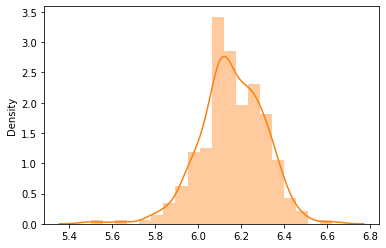

IntegratedGradients 1 [-inf]
IntegratedGradients 1 [-inf]
GradCAM 42 [      -inf 6.64659437 6.64734493 6.64839458 6.65630687 6.66671741
 6.67308019 6.67428119 6.68107231 6.69184401 6.69272315 6.70027438
 6.70112223 6.71557697 6.71711438 6.71839312 6.71847811 6.72435483
 6.73115671 6.73220201 6.7388738  6.74527001 6.74560923 6.74565541
 6.74893184 6.75052365 6.75319063 6.75483208 6.76734605 6.76764837
 6.76972477 6.77409864 6.78118337 6.78503608 6.78669444 6.78908968
 6.80073333 6.80403182 6.8473973  6.84910536 6.85833277 6.88861441]
GradCAM 42 [      -inf 6.64659437 6.64734493 6.64839458 6.65630687 6.66671741
 6.67308019 6.67428119 6.68107231 6.69184401 6.69272315 6.70027438
 6.70112223 6.71557697 6.71711438 6.71839312 6.71847811 6.72435483
 6.73115671 6.73220201 6.7388738  6.74527001 6.74560923 6.74565541
 6.74893184 6.75052365 6.75319063 6.75483208 6.76734605 6.76764837
 6.76972477 6.77409864 6.78118337 6.78503608 6.78669444 6.78908968
 6.80073333 6.80403182 6.8473973  6.84910536 6.8

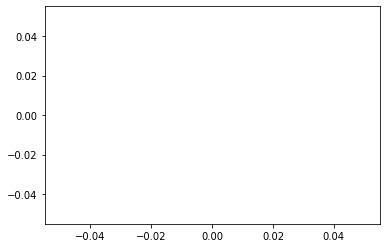

In [ ]:
for k in ['Gradient', 'Saliency', 'IntegratedGradients', 'GradCAM', 'Occlusion', 'GradientShap']:
    scores = benchmark_cmnist["Complexity"]["Complexity"]["results_eval_scores"]["Model Adversary Test"][k]
    print(k, len(np.unique(scores)), np.unique(scores))
    if not np.isnan(scores).all():
        try:
            scores = scores[~np.isnan(scores)]
        except:
            pass
        try:
            sns.distplot(scores)
            plt.show()
        except:
            pass

In [ ]:
benchmark_fmnist["Complexity"]["Complexity"]["results_eval_scores_perturbed"]["Model Resilience Test"].keys()

dict_keys(['0', '1', '2'])

### Create tables

In [ ]:
#df_inter_averages[df_inter_averages.reset_index().index % 2 == 0][analyser_suite].style.background_gradient(axis=None) 

In [ ]:
benchmark = benchmark_mnist 
estimator_category = "Complexity"
estimator_name = "Sparseness"
perturbation_type = "Model"
benchmark[estimator_category][estimator_name].keys()

dict_keys(['results_intra_scores', 'results_inter_scores', 'results_eval_scores', 'results_eval_scores_perturbed', 'results_indices_perturbed', 'results_meta_consistency_scores', 'results_consistency_scores'])

In [ ]:
benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]

{'consistency_scores': {'IAC_{NR}': [0.1810407345374781,
   0.22237712636133858,
   0.22411554200217576],
  'IAC_{AR}': [0.8883650626737288, 0.959337484954501, 0.9911226082834819],
  'IEC_{NR}': [0.8365885416666666, 0.8357421875, 0.8382161458333333],
  'IEC_{AR}': [0.5369748581776485, 0.577344579843096, 0.5919424115470073]},
 'consistency_results': {'IAC_{NR} mean': 0.20917780096699748,
  'IAC_{NR} std': 0.0199085643661125,
  'IAC_{AR} mean': 0.9462750519705706,
  'IAC_{AR} std': 0.0199085643661125,
  'IEC_{NR} mean': 0.8368489583333334,
  'IEC_{NR} std': 0.0010266385566419021,
  'IEC_{AR} mean': 0.5687539498559172,
  'IEC_{AR} std': 0.023248041832030924},
 'MC_means': [0.6107422992638805, 0.6487003446647338, 0.6613491769164996],
 'MC_mean': 0.6402639402817047,
 'MC_std': 0.02150416557510485}

In [ ]:
benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"]["Input"]

{'consistency_scores': {'IAC_{NR}': [0.9627991552731717,
   0.9372273278051642,
   0.8869845276199181],
  'IAC_{AR}': [0.04288004793984544, 0.05906433950641208, 0.056092342999535465],
  'IEC_{NR}': [0.8373046875, 0.8428385416666668, 0.8401041666666667],
  'IEC_{AR}': [0.0835166084849898, 0.08421749342085219, 0.0845970836061416]},
 'consistency_results': {'IAC_{NR} mean': 0.9290036702327513,
  'IAC_{NR} std': 0.03149270655725015,
  'IAC_{AR} mean': 0.052678910148597664,
  'IAC_{AR} std': 0.03149270655725015,
  'IEC_{NR} mean': 0.8400824652777779,
  'IEC_{NR} std': 0.0022592386176458943,
  'IEC_{AR} mean': 0.0841103951706612,
  'IEC_{AR} std': 0.0004475556935566608},
 'MC_means': [0.4816251247995017, 0.4808369255997738, 0.4669445302230655],
 'MC_mean': 0.476468860207447,
 'MC_std': 0.006742401191126426}

In [ ]:
benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["consistency_scores"].keys()

dict_keys(['IAC_{NR}', 'IAC_{AR}', 'IEC_{NR}', 'IEC_{AR}'])

In [ ]:
def make_benchmarking_df(benchmark: dict,
                         estimators: dict):
    df = pd.DataFrame(columns=["Category", "Estimator", "Test", "IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}", "MC"])
    scores = ["IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}"]

    means_all = []
    stds_all = []
    row= 0
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            for px, perturbation_type in enumerate(["Model", "Input"]):
                
                means = []
                stds = []

                row += ex1+ex2+px
                df.loc[row, "Test"] = perturbation_type
                if px == 1:
                    df.loc[row, "Category"] = estimator_category
                    df.loc[row, "Estimator"] = estimator_name
                else:
                    df.loc[row, "Category"] = estimator_category
                    df.loc[row, "Estimator"] = estimator_name
                    
                
                for s in scores:
                    score = np.array(benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["consistency_scores"][s])
                    df.loc[row, s] = f"{score.mean():.3f}"+" $\pm$ "+f"{score.std()*2:.3f}"
                    means.append(score.mean())
                    stds.append(score.std())

                mc_mean = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                mc_std = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]
                df.loc[row, "MC"] = f"{mc_mean:.3f}"+" $\pm$ "+f"{mc_std*2:.3f}"

                means.append(mc_mean)
                stds.append(mc_std)

                means_all.append(means)
                stds_all.append(stds)

    means_all = np.array(means_all)
    stds_all = np.array(stds_all)

    return df

In [ ]:
def prepare_df_cleanup(df):
    row = 0
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            for px, perturbation_type in enumerate(["Model", "Input"]):

                row += ex1+ex2+px
                if px == 1:
                    df.loc[row, "Category"] = ""
                    df.loc[row, "Estimator"] = ""
                else:
                    df.loc[row, "Category"] = "\multirow{ 4}{*}{\textit{"+estimator_category+"}}"
                    df.loc[row, "Estimator"] = "\multirow{ 2}{*}{\textit{"+estimator_name+"}}"

    df.drop(columns="Test", inplace=True)
    return df

In [ ]:
df_mnist = make_benchmarking_df(benchmark=benchmark_mnist, estimators=estimators)
df_mnist_cleaned = prepare_df_cleanup(df=df_mnist)
df_mnist_cleaned

,Category,Estimator,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR},MC
0,\multirow{ 4}{*}{\textit{Complexity}},\multirow{ 2}{*}{\textit{Sparseness}},0.209 $\pm$ 0.040,0.946 $\pm$ 0.086,0.837 $\pm$ 0.002,0.569 $\pm$ 0.046,0.640 $\pm$ 0.043
1,,,0.929 $\pm$ 0.063,0.053 $\pm$ 0.014,0.840 $\pm$ 0.005,0.084 $\pm$ 0.001,0.476 $\pm$ 0.013
2,\multirow{ 4}{*}{\textit{Complexity}},\multirow{ 2}{*}{\textit{Complexity}},0.009 $\pm$ 0.013,1.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.156 $\pm$ 0.014,0.541 $\pm$ 0.007
4,,,0.167 $\pm$ 0.000,0.833 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,0.500 $\pm$ 0.000
5,\multirow{ 4}{*}{\textit{Faithfulness}},\multirow{ 2}{*}{\textit{Faithfulness Correlat...,0.477 $\pm$ 0.032,0.900 $\pm$ 0.023,0.190 $\pm$ 0.003,0.579 $\pm$ 0.008,0.537 $\pm$ 0.003
7,,,0.500 $\pm$ 0.107,0.890 $\pm$ 0.005,0.190 $\pm$ 0.002,0.594 $\pm$ 0.005,0.543 $\pm$ 0.026
9,\multirow{ 4}{*}{\textit{Faithfulness}},\multirow{ 2}{*}{\textit{Pixel-Flipping}},0.547 $\pm$ 0.139,0.963 $\pm$ 0.034,0.299 $\pm$ 0.001,0.626 $\pm$ 0.046,0.609 $\pm$ 0.039
12,,,0.485 $\pm$ 0.141,1.000 $\pm$ 0.000,0.294 $\pm$ 0.006,0.796 $\pm$ 0.006,0.644 $\pm$ 0.038
14,\multirow{ 4}{*}{\textit{Localisation}},\multirow{ 2}{*}{\textit{Pointing-Game}},0.977 $\pm$ 0.005,0.607 $\pm$ 0.075,0.996 $\pm$ 0.000,0.108 $\pm$ 0.012,0.672 $\pm$ 0.020
17,,,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,0.500 $\pm$ 0.000


In [ ]:
df_mnist_cleaned.to_latex()

'\\begin{tabular}{llllllll}\n\\toprule\n{} &                                  Category &                                          Estimator &           IAC\\_\\{NR\\} &           IAC\\_\\{AR\\} &           IEC\\_\\{NR\\} &           IEC\\_\\{AR\\} &                 MC \\\\\n\\midrule\n0  &     \\textbackslash multirow\\{ 4\\}\\{*\\}\\{\\textbackslash textit\\{Complexity\\}\\} &              \\textbackslash multirow\\{ 2\\}\\{*\\}\\{\\textbackslash textit\\{Sparseness\\}\\} &  0.209 \\$\\textbackslash pm\\$ 0.040 &  0.946 \\$\\textbackslash pm\\$ 0.086 &  0.837 \\$\\textbackslash pm\\$ 0.002 &  0.569 \\$\\textbackslash pm\\$ 0.046 &  0.640 \\$\\textbackslash pm\\$ 0.043 \\\\\n1  &                                           &                                                    &  0.929 \\$\\textbackslash pm\\$ 0.063 &  0.053 \\$\\textbackslash pm\\$ 0.014 &  0.840 \\$\\textbackslash pm\\$ 0.005 &  0.084 \\$\\textbackslash pm\\$ 0.001 &  0.476 \\$\\textbackslash pm\\$ 0.013 \\\\\n2  &     \

In [ ]:
df_fmnist = make_benchmarking_df(benchmark=benchmark_fmnist, estimators=estimators)
df_fmnist

,Category,Estimator,Test,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR},MC
0,Complexity,Sparseness,Model,0.145 $\pm$ 0.039,0.915 $\pm$ 0.045,0.831 $\pm$ 0.004,0.492 $\pm$ 0.082,0.596 $\pm$ 0.012
1,Complexity,Sparseness,Input,0.917 $\pm$ 0.036,0.070 $\pm$ 0.003,0.832 $\pm$ 0.003,0.083 $\pm$ 0.001,0.475 $\pm$ 0.010
2,Complexity,Complexity,Model,0.050 $\pm$ 0.047,0.990 $\pm$ 0.027,0.999 $\pm$ 0.000,0.086 $\pm$ 0.028,0.532 $\pm$ 0.014
4,Complexity,Complexity,Input,0.167 $\pm$ 0.000,0.833 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,0.500 $\pm$ 0.000
5,Faithfulness,Faithfulness Correlation,Model,0.527 $\pm$ 0.030,0.857 $\pm$ 0.072,0.198 $\pm$ 0.008,0.515 $\pm$ 0.004,0.524 $\pm$ 0.021
7,Faithfulness,Faithfulness Correlation,Input,0.448 $\pm$ 0.087,0.994 $\pm$ 0.003,0.196 $\pm$ 0.004,0.504 $\pm$ 0.002,0.536 $\pm$ 0.021
9,Faithfulness,Pixel-Flipping,Model,0.447 $\pm$ 0.050,0.958 $\pm$ 0.088,0.329 $\pm$ 0.002,0.558 $\pm$ 0.032,0.573 $\pm$ 0.025
12,Faithfulness,Pixel-Flipping,Input,0.453 $\pm$ 0.073,1.000 $\pm$ 0.000,0.324 $\pm$ 0.001,0.817 $\pm$ 0.003,0.649 $\pm$ 0.018
14,Localisation,Pointing-Game,Model,0.950 $\pm$ 0.025,0.634 $\pm$ 0.032,0.995 $\pm$ 0.001,0.084 $\pm$ 0.018,0.666 $\pm$ 0.009
17,Localisation,Pointing-Game,Input,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,1.000 $\pm$ 0.000,0.000 $\pm$ 0.000,0.500 $\pm$ 0.000


In [ ]:
df_cmnist = make_benchmarking_df(benchmark=benchmark_cmnist, estimators=estimators)
df_cmnist

,Category,Estimator,Test,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR},MC
0,Complexity,Sparseness,Model,0.352 $\pm$ 0.061,0.989 $\pm$ 0.017,0.814 $\pm$ 0.001,0.670 $\pm$ 0.016,0.706 $\pm$ 0.013
1,Complexity,Sparseness,Input,0.626 $\pm$ 0.099,0.313 $\pm$ 0.028,0.830 $\pm$ 0.005,0.333 $\pm$ 0.006,0.525 $\pm$ 0.018
2,Complexity,Complexity,Model,0.056 $\pm$ 0.084,1.000 $\pm$ 0.000,0.996 $\pm$ 0.001,0.209 $\pm$ 0.013,0.565 $\pm$ 0.024
4,Complexity,Complexity,Input,0.062 $\pm$ 0.010,0.928 $\pm$ 0.047,1.000 $\pm$ 0.000,0.080 $\pm$ 0.005,0.518 $\pm$ 0.013
5,Faithfulness,Faithfulness Correlation,Model,0.508 $\pm$ 0.061,0.939 $\pm$ 0.017,0.182 $\pm$ 0.004,0.622 $\pm$ 0.005,0.563 $\pm$ 0.017
7,Faithfulness,Faithfulness Correlation,Input,0.490 $\pm$ 0.031,0.934 $\pm$ 0.018,0.188 $\pm$ 0.008,0.634 $\pm$ 0.012,0.562 $\pm$ 0.010
9,Faithfulness,Pixel-Flipping,Model,0.565 $\pm$ 0.040,0.965 $\pm$ 0.022,0.287 $\pm$ 0.005,0.526 $\pm$ 0.080,0.586 $\pm$ 0.022
12,Faithfulness,Pixel-Flipping,Input,0.495 $\pm$ 0.037,0.995 $\pm$ 0.001,0.295 $\pm$ 0.012,0.701 $\pm$ 0.002,0.621 $\pm$ 0.010
14,Localisation,Pointing-Game,Model,0.967 $\pm$ 0.000,1.000 $\pm$ 0.000,0.997 $\pm$ 0.000,0.527 $\pm$ 0.040,0.873 $\pm$ 0.010
17,Localisation,Pointing-Game,Input,0.995 $\pm$ 0.003,0.013 $\pm$ 0.003,0.999 $\pm$ 0.001,0.001 $\pm$ 0.000,0.502 $\pm$ 0.001


In [ ]:
df_mnist.iloc[:, 3:].to_latex(multirow=True)

'\\begin{tabular}{lllll}\n\\toprule\n{} &           IAC\\_\\{AR\\} &           IEC\\_\\{NR\\} &           IEC\\_\\{AR\\} &                 MC \\\\\n\\midrule\n0  &  0.946 \\$\\textbackslash pm\\$ 0.086 &  0.837 \\$\\textbackslash pm\\$ 0.002 &  0.569 \\$\\textbackslash pm\\$ 0.046 &  0.640 \\$\\textbackslash pm\\$ 0.043 \\\\\n1  &  0.053 \\$\\textbackslash pm\\$ 0.014 &  0.840 \\$\\textbackslash pm\\$ 0.005 &  0.084 \\$\\textbackslash pm\\$ 0.001 &  0.476 \\$\\textbackslash pm\\$ 0.013 \\\\\n2  &  1.000 \\$\\textbackslash pm\\$ 0.000 &  1.000 \\$\\textbackslash pm\\$ 0.000 &  0.156 \\$\\textbackslash pm\\$ 0.014 &  0.541 \\$\\textbackslash pm\\$ 0.007 \\\\\n4  &  0.833 \\$\\textbackslash pm\\$ 0.000 &  1.000 \\$\\textbackslash pm\\$ 0.000 &  0.000 \\$\\textbackslash pm\\$ 0.000 &  0.500 \\$\\textbackslash pm\\$ 0.000 \\\\\n5  &  0.900 \\$\\textbackslash pm\\$ 0.023 &  0.190 \\$\\textbackslash pm\\$ 0.003 &  0.579 \\$\\textbackslash pm\\$ 0.008 &  0.537 \\$\\textbackslash pm\\$ 0.003 \\

### Create scatter plots

In [ ]:
def make_scatter_df(benchmark: dict,
                    estimators: dict):
    df = pd.DataFrame(columns=["Category", "Estimator", "Test", "IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}", "MC", "IAC_{NR} std", "IAC_{AR} std", "IEC_{NR} std", "IEC_{AR} std", "MC std"])
    scores = ["IAC_{NR}", "IAC_{AR}", "IEC_{NR}", "IEC_{AR}"]

    row= 0
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            for px, perturbation_type in enumerate(["Model", "Input"]):

                row += ex1+ex2+px
                df.loc[row, "Test"] = perturbation_type
                df.loc[row, "Category"] = estimator_category
                df.loc[row, "Estimator"] = estimator_name
                for s in scores:
                    score = np.array(benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["consistency_scores"][s])
                    df.loc[row, s] = score.mean()
                    df.loc[row, s+" std"] = score.std()*2

                df.loc[row, "MC"] = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                df.loc[row, "MC std"] = benchmark[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]*2

    return df

In [ ]:
df_mnist = make_scatter_df(benchmark=benchmark_mnist, estimators=estimators)
df_fmnist = make_scatter_df(benchmark=benchmark_fmnist, estimators=estimators)
df_cmnist = make_scatter_df(benchmark=benchmark_cmnist, estimators=estimators)

In [ ]:
df_mnist[["IAC_{NR}","IAC_{AR}","IEC_{NR}","IEC_{AR}","MC","IAC_{NR} std","IAC_{AR} std","IEC_{NR} std","IEC_{AR} std","MC std"]] = df_mnist[["IAC_{NR}","IAC_{AR}","IEC_{NR}","IEC_{AR}","MC","IAC_{NR} std","IAC_{AR} std","IEC_{NR} std","IEC_{AR} std","MC std"]].astype(float)

In [ ]:
df_mnist.describe()

,IAC_{NR},IAC_{AR},IEC_{NR},IEC_{AR},MC,IAC_{NR} std,IAC_{AR} std,IEC_{NR} std,IEC_{AR} std,MC std
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000,20.000000
mean,0.473490,0.775584,0.734417,0.425288,0.602195,0.053513,2.270145e-02,0.002227,0.012911,0.015809
std,0.289992,0.330007,0.270863,0.290991,0.088950,0.045616,2.855893e-02,0.001835,0.016242,0.014288
min,0.008929,0.000000,0.189920,0.000000,0.476469,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.256070,0.803088,0.714160,0.101779,0.540023,0.017341,1.665335e-16,0.000806,0.000833,0.004356
50%,0.480624,0.917631,0.821463,0.557211,0.610546,0.046897,1.530868e-02,0.002018,0.005846,0.011239
75%,0.546908,0.964309,0.910878,0.602041,0.650647,0.071318,2.899826e-02,0.003199,0.018637,0.026275
max,1.000000,1.000000,1.000000,0.795752,0.755510,0.140686,8.774751e-02,0.006252,0.046496,0.043008


In [ ]:
df_mnist.groupby(["Estimator"])["MC"].mean()

Estimator
Complexity                            0.520568
Faithfulness Correlation              0.540044
Local Lipschitz Estimate              0.740861
Max-Sensitivity                       0.649199
Model Parameter Randomisation Test    0.583091
Pixel-Flipping                        0.626093
Pointing-Game                         0.585881
Random Logit                          0.666024
Relevance Mass Accuracy               0.551821
Sparseness                            0.558366
Name: MC, dtype: float64

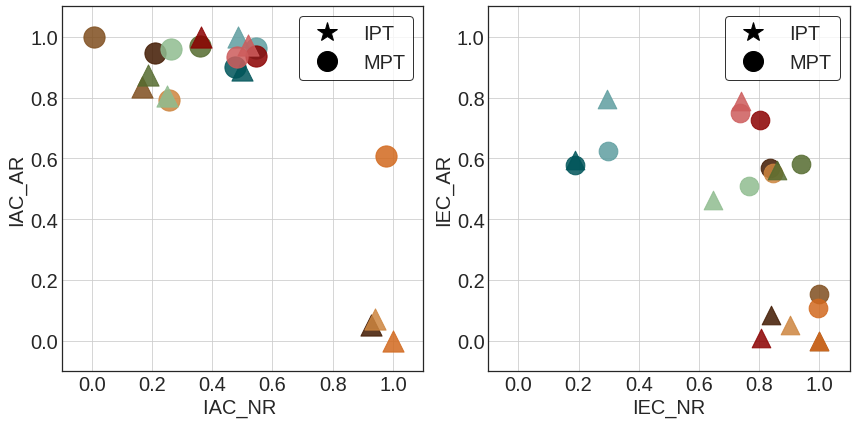

In [ ]:
import matplotlib.lines as mlines

df = df_mnist

legend_elements = [mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=20, label='IPT'), 
                   mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=20, label='MPT')]
markers = {"Input": "^", "Model": "o"} # ['s', '*', '^']


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
for x, y, col, t in zip(df["IAC_{NR}"].values, df["IAC_{AR}"].values, df["Estimator"].values, df["Test"].values):
    ax[0].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=450, label=t, alpha=0.85)

for x, y, col, t in zip(df["IEC_{NR}"].values, df["IEC_{AR}"].values, df["Estimator"].values, df["Test"].values):
    ax[1].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=350, label=t, alpha=0.85)

ax[0].legend(handles=legend_elements,  fontsize=20, frameon=True, edgecolor="black")
ax[0].set_ylabel("IAC_AR", fontsize=20)
ax[0].set_xlabel("IAC_NR ", fontsize=20)
ax[0].set_ylim(-0.1, 1.1)
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax[0].set_xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax[0].grid()

ax[1].legend(handles=legend_elements,  fontsize=20, frameon=True, edgecolor="black")
ax[1].set_ylabel("IEC_AR", fontsize=20)
ax[1].set_xlabel("IEC_NR", fontsize=20)
ax[1].set_ylim(-0.1, 1.1)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_yticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax[1].set_xticks(ticks=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=20)
ax[1].grid()
plt.tight_layout()

### Area graph single

In [ ]:
from typing import Optional
from itertools import cycle
cycol = cycle('bgrcmk')

def plot_single_estimator_area(benchmark: dict,
                        estimator_category: str, 
                        estimator_name: str,
                        perturbation_type: str,
                        title: Optional[str] = "",
                        ):
    
    #try: 
    scores = {
        "IAC_NR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_res"]).flatten(),
        "IAC_AR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_adv"]).flatten(),
        "IEC_NR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_res"]).flatten(),
        "IEC_AR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_adv"]).flatten(),
    }

    mc_scores = [np.mean(scores["IAC_NR"]), np.mean(scores["IAC_AR"]), np.mean(scores["IEC_NR"]), np.mean(scores["IEC_AR"])]

    fig = plt.figure(figsize=(3, 3))
    ax = plt.axes()
    plt.grid()
    plt.title(f"{estimator_name} ({np.mean(mc_scores):.3f}) \n {perturbation_type} - {title}", fontsize=12)

    X_gt = [-1, 0, 1, 0]
    Y_gt = [0, 1, 0, -1]
    X_area = [-scores["IAC_AR"].mean(), 0, scores["IEC_AR"].mean(), 0]
    Y_area = [0, scores["IAC_NR"].mean(), 0, -scores["IEC_NR"].mean()]
        
    #print([IAC_AR.mean(), IEC_AR.mean(), IAC_NR.mean(), IEC_NR.mean()])
    plt.fill(X_gt, Y_gt, color="black", alpha=0.1)
    plt.fill(X_area, Y_area, color=next(cycol), alpha=0.8, edgecolor="black")

    # Annotate.
    plt.annotate("${IAC}_{AR}$"+f'={scores["IAC_AR"].mean():.2f}', (-scores["IAC_AR"].mean(), 0.1), fontsize=12)
    plt.annotate("${IAC}_{NR}$"+f'={scores["IAC_NR"].mean():.2f}', (-0.2, scores["IAC_NR"].mean()+0.05), fontsize=12)
    plt.annotate("${IEC}_{AR}$"+f'={scores["IEC_AR"].mean():.2f}', (scores["IEC_AR"].mean(), 0.1), fontsize=12)
    plt.annotate("${IEC}_{NR}$"+f'={scores["IEC_NR"].mean():.2f}', (-0.2, -scores["IEC_NR"].mean()-0.1), fontsize=12)
    
    # Labels.
    ax.set_xticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    ax.set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    #if title:
    #print(f"{estimator_name} ({np.mean(list(scores.values()))}) \n {title}")
    
    
    #else:
    #    plt.title(f"{estimator_name}", fontsize=20)
    
    # Limits.
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.show()
    
    return fig, scores

    #except:
    #    pass #print(f"Could not find data to plot for estimator={estimator_name}.")

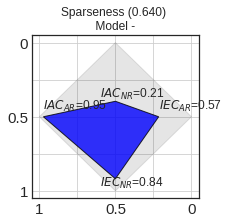

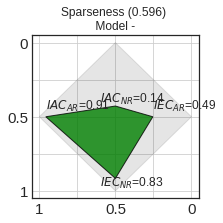

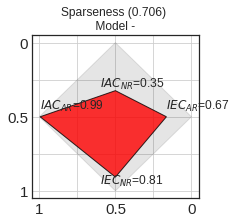

In [ ]:
estimator_category = "Complexity"
estimator_name = "Sparseness" 
perturbation_type = "Model"

plot_single_estimator_area(benchmark_mnist, estimator_category, estimator_name, perturbation_type);
plot_single_estimator_area(benchmark_fmnist, estimator_category, estimator_name, perturbation_type);
plot_single_estimator_area(benchmark_cmnist, estimator_category, estimator_name, perturbation_type);

### Area graph full

In [ ]:
def plot_multiple_estimator_area(benchmark: dict,
                                 estimators: dict,
                                 average_over: list = ["Model", "Input"],
                                 dataset_name=""):
    
    fig, axs = plt.subplots(2, 5, sharex=True, figsize=(20, 8)) #sharex=True, sharey=True, 

    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            scores = []
            for px, perturbation_type in enumerate(["Input", "Model"]):
                
                intra_scores_res = np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_res"]).flatten()
                intra_scores_adv = np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_adv"]).flatten()
                inter_scores_res = np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_res"]).flatten()
                inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_adv"]).flatten()
                
                X_gt = [-1, 0, 1, 0]
                Y_gt = [0, 1, 0, -1]
                X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
                Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

                if perturbation_type in average_over: 
                    score = np.array([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
                    scores.append(score) 

                if perturbation_type == "Input":
                    axs[ex2, ex1].fill(X_area, Y_area, color=colours[estimator_name], alpha=0.75, label=perturbation_type, edgecolor="black")
                else:
                    axs[ex2, ex1].fill(X_area, Y_area, color=colours[estimator_name], alpha=0.5, label=perturbation_type, hatch = '/', edgecolor="black")
                
                if px == 1:
                    axs[ex2, ex1].fill(X_gt, Y_gt, color="black", alpha=0.075, label="m*")

                # Annotate.
                #axs[ex2, ex1].annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
                #axs[ex2, ex1].annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
                #axs[ex2, ex1].annotate("\n\n${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
                #axs[ex2, ex1].annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
                
                axs[ex2, ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
                axs[ex2, ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
                axs[ex2, ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
                axs[ex2, ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)
            
            # Labels.
            axs[ex2, ex1].set_xticklabels(["", "1", "0.5",  "0", "0.5", "1"], fontsize=14)
            
            axs[ex2, ex1].set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=14)
            if estimator_name == "Model Parameter Randomisation Test":
                estimator_name = "Model Parameter Random."
            
            #print(scores)
            axs[ex2, ex1].set_title(f"{estimator_name} ({np.array(scores).flatten().mean():.4f})", fontsize=14)
            axs[ex2, ex1].grid()
            axs[ex2, ex1].legend(loc="upper left")

            #axs[ex2, ex1].plot([0, 0], [-1, 1], '--bo', label='NR')
            #axs[ex2, ex1].plot([-1, 1], [0, 0], '--go', label='AR')

            # Limits.
            #axs[ex2, ex1].set_xlim(-1.6, 1.6)
            #axs[ex2, ex1].set_ylim(-1.6, 1.6)
            plt.grid()

    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"full_area_graph_{dataset_name}.png", dpi=1000)
    plt.show()
                

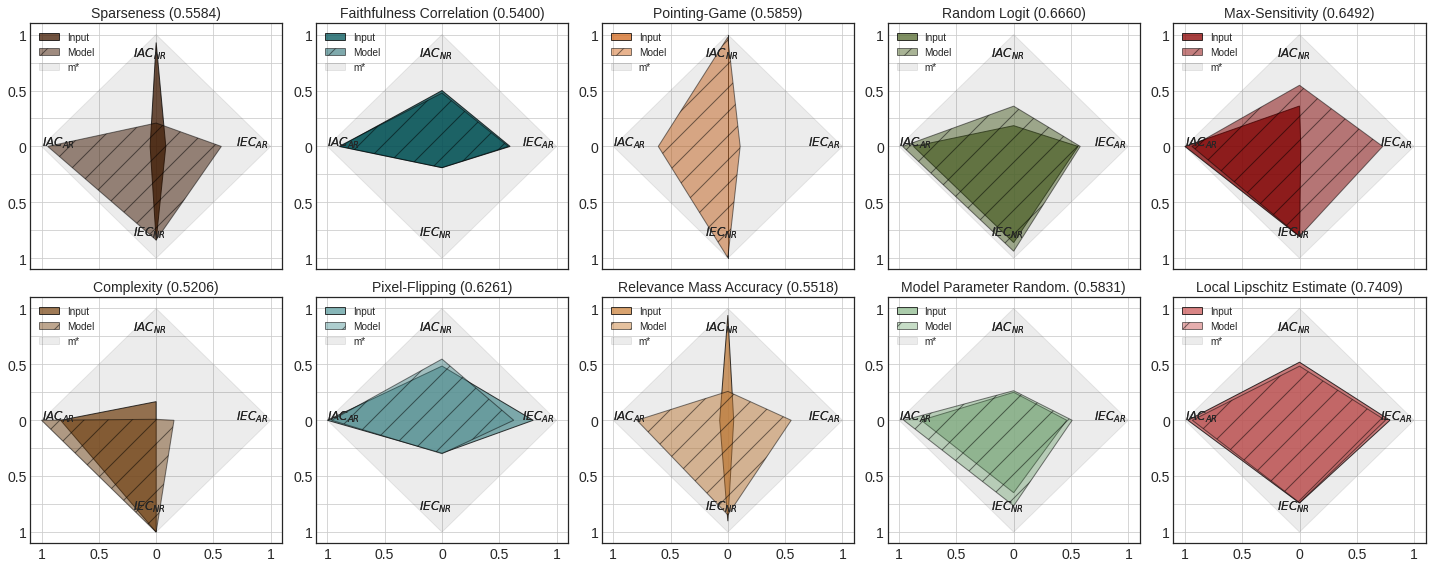

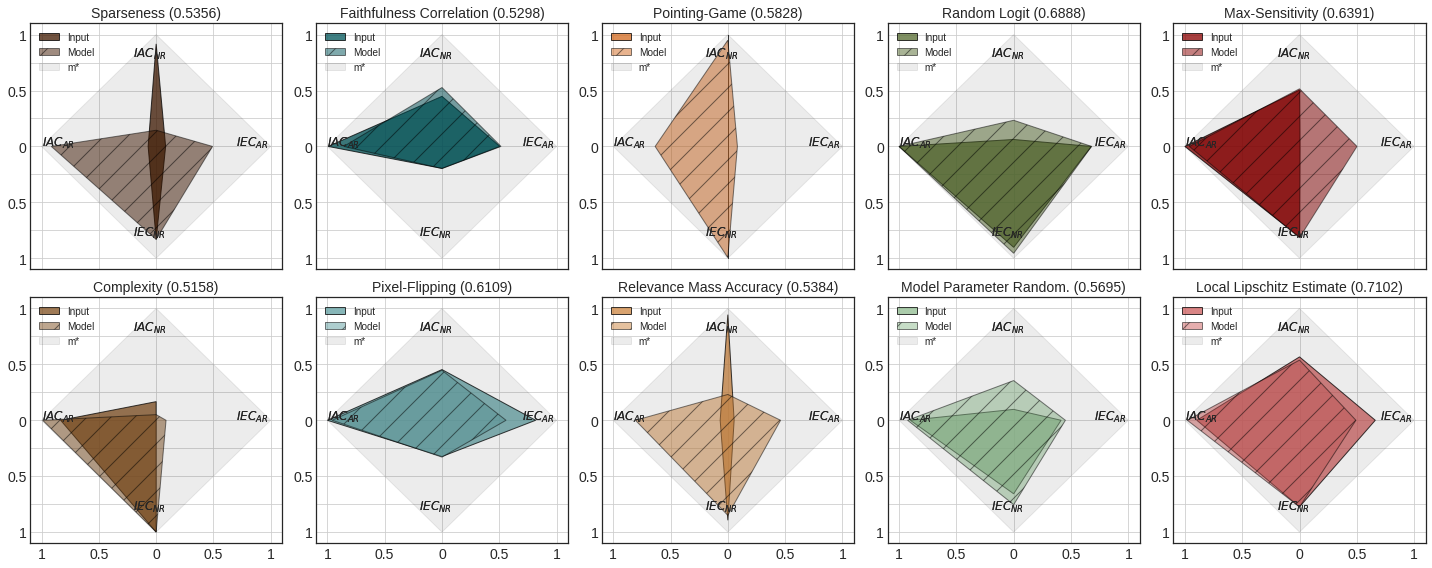

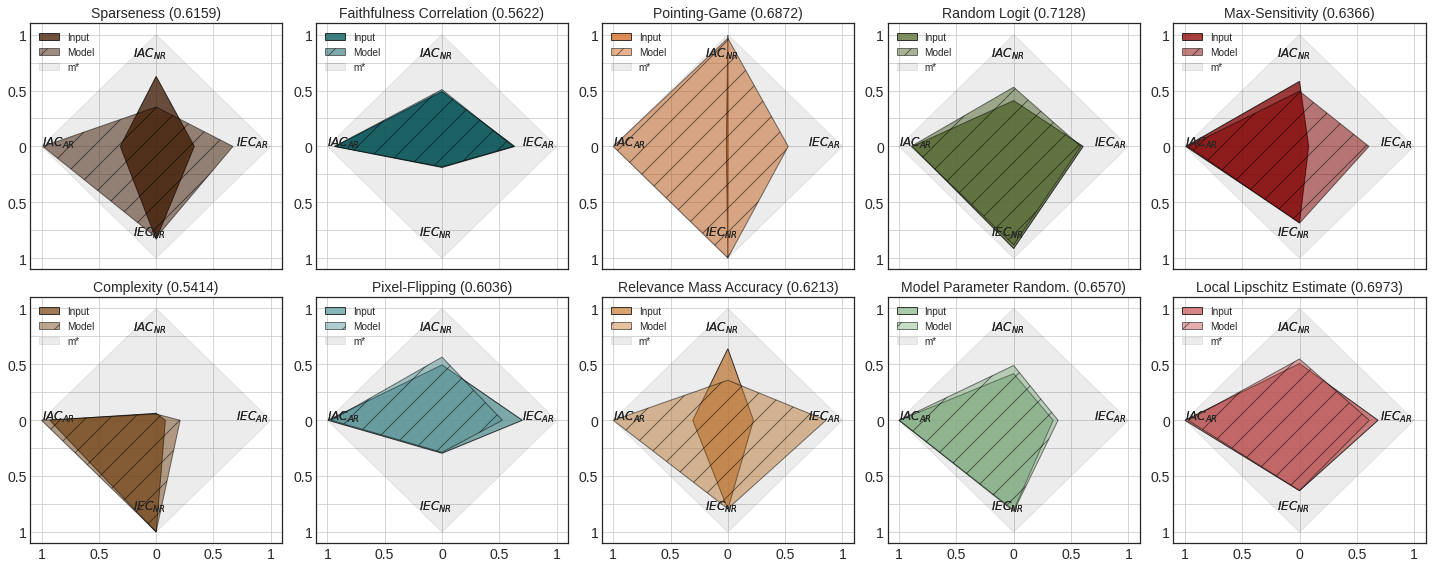

In [ ]:
plot_multiple_estimator_area(benchmark=benchmark_mnist, estimators=estimators, average_over=["Model", "Input"], dataset_name="MNIST");
plot_multiple_estimator_area(benchmark=benchmark_fmnist, estimators=estimators, average_over=["Model", "Input"], dataset_name="fMNIST");
plot_multiple_estimator_area(benchmark=benchmark_cmnist, estimators=estimators, average_over=["Model", "Input"], dataset_name="cMNIST");

## Analyse combined


In [ ]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, min(y_value*1.1, 0.85)),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.



In [ ]:
def get_benchmark_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types):

    # Collect the data.
    mnist_means = []
    mnist_stds = []
    fmnist_means = []
    fmnist_stds = []
    cmnist_means = []
    cmnist_stds = []

    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            mnist_means_per = []
            mnist_stds_per = []
            fmnist_means_per = []
            fmnist_stds_per = []
            cmnist_means_per = []
            cmnist_stds_per = []

            for px, perturbation_type in enumerate(perturbation_types):
                #print(estimator_category, estimator_name)
                
                mnist_mean = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                mnist_std = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]
                mnist_means_per.append(mnist_mean)
                mnist_stds_per.append(mnist_std)

                fmnist_mean = benchmark_fmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                fmnist_std = benchmark_fmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]
                fmnist_means_per.append(fmnist_mean)
                fmnist_stds_per.append(fmnist_std)

                cmnist_mean = benchmark_cmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_mean"]
                cmnist_std = benchmark_cmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]
                cmnist_means_per.append(cmnist_mean)
                cmnist_stds_per.append(cmnist_std)
            
            mnist_means.append(np.mean(mnist_means_per))
            mnist_stds.append(np.mean(mnist_stds_per))
            fmnist_means.append(np.mean(fmnist_means_per))
            fmnist_stds.append(np.mean(fmnist_stds_per))
            cmnist_means.append(np.mean(cmnist_means_per))
            cmnist_stds.append(np.mean(cmnist_stds_per))
            

    means = np.array([[a, b, c] for a, b, c in zip(mnist_means, fmnist_means, cmnist_means)]).flatten()
    stds = np.array([[a, b, c] for a, b, c in zip(mnist_stds, fmnist_stds, cmnist_stds)]).flatten()

    return means, stds

In [ ]:
import matplotlib.lines as mlines

def plot_combined(df: pd.DataFrame, 
                  means: list,
                  stds: list, 
                  dataset_name: str):

    legend_elements = [mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=10, label='IPT'), 
                    mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=10, label='MPT')]
    markers = {"Input": "^", "Model": "o"} # ['s', '*', '^']


    fig, ax = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1, 4]})

    
    for x, y, col, t in zip(df["IAC_{NR}"].values, df["IAC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[0].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")
    for x, y, col, t in zip(df["IEC_{NR}"].values, df["IEC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[1].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")
    """
    df = df_fmnist
    for x, y, col, t in zip(df["IAC_{NR}"].values, df["IAC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[0].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")
    for x, y, col, t in zip(df["IEC_{NR}"].values, df["IEC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[1].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")

    df = df_cmnist
    for x, y, col, t in zip(df["IAC_{NR}"].values, df["IAC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[0].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")
    for x, y, col, t in zip(df["IEC_{NR}"].values, df["IEC_{AR}"].values, df["Estimator"].values, df["Test"].values):
        ax[1].scatter(x=x, y=y, marker=markers[t], c=colours[col], s=100, label=t, alpha=0.65, edgecolor="black")
    """

    ax[0].legend(handles=legend_elements,  fontsize=15, frameon=True, edgecolor="black", loc="lower left")
    ax[0].set_ylabel("$\mathbf{IAC}_{AR}$", fontsize=20)
    ax[0].set_xlabel("$\mathbf{IAC}_{NR}$", fontsize=20)
    ax[0].set_ylim(-0.1, 1.1)
    ax[0].set_xlim(-0.1, 1.1)
    ax[0].set_xticks(ticks=np.linspace(0, 1, 10), labels=[0.0, "", "", "", "", "", "", "", "", 1.0], fontsize=15)
    ax[0].set_yticks(ticks=np.linspace(0, 1, 10), labels=[0.0, "", "", "", "", 0.5, "", "", "", 1.0], fontsize=15)
    ax[0].grid()

    ax[1].legend(handles=legend_elements,  fontsize=15, frameon=True, edgecolor="black", loc="lower left")
    ax[1].set_ylabel("$\mathbf{IEC}_{AR}$", fontsize=20)
    ax[1].set_xlabel("$\mathbf{IEC}_{NR}$", fontsize=20)
    ax[1].set_ylim(-0.1, 1.1)
    ax[1].set_xlim(-0.1, 1.1)
    ax[1].set_xticks(ticks=np.linspace(0, 1, 10), labels=[0.0, "", "", "", "", "", "", "", "", 1.0], fontsize=15)
    ax[1].set_yticks(ticks=np.linspace(0, 1, 10), labels=[0.0, "", "", "", "", 0.5, "", "", "", 1.0], fontsize=15)
    ax[1].grid()

    # MNIST, fMNIST, cMNIST
    datasets = ["MNIST", "fMNIST", "cMNIST"]
    nr_datasets = 3

    metrics_short = ["SP", "CO", "FC", "PF", "PG", "RMA", "RL", "MPR", "MS", "LLE"]
    colours_repeat = np.repeat(list(colours.values()), repeats=nr_datasets)
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="/"), 
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="*"),
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black'),]

    x = [ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 38]
    labels_ticks = list(range(1, np.max(x)+1, nr_datasets+1))
    labels_ticks[0] = 1.5

    # Plot!
    barlist = ax[2].bar(x, means, yerr=stds, alpha=0.85, edgecolor="black")

    # Alt 1.
    ax[2].bar_label(barlist, fmt='%.2f', label_type='edge', fontsize=10)

    # Alt 2.
    # Call the function above. All the magic happens there.
    #add_value_labels(ax=ax[2])

    for i in range(0, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('/')
    for i in range(1, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('*')
    for i in range(len(metrics_short)*nr_datasets):
        barlist[i].set_color(colours_repeat[i])
    for i in range(len(metrics_short)*nr_datasets):
        barlist[i].set_edgecolor("black")

    ax[2].set_xticks(ticks=labels_ticks, labels=metrics_short, fontsize=20)#, rotation=90)
    ax[2].set_ylabel("$\mathbf{MC}$", fontsize=20)
    ax[2].set_yticks(ticks=np.linspace(0.5, 1.0, 10), labels=[0.5, "", 0.6, "", 0.7, "", 0.8, "", 0.9, ""], fontsize=15)
    ax[2].set_ylim(np.min(means)-0.1, np.max(means)+0.1)
    ax[2].legend(handles=legend_elements, labels=datasets, ncol=3, fontsize=15, loc="upper left") # loc=2,
    ax[2].grid()
    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"benchmarking_{dataset_name}.png", dpi=1000)
    plt.show()

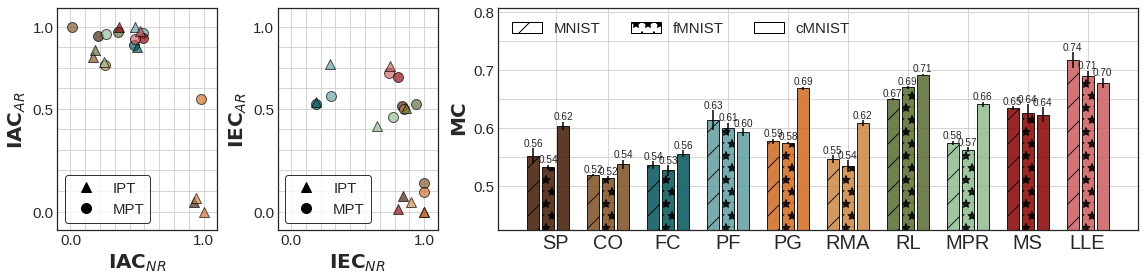

In [ ]:
means, stds = get_benchmark_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model", "Input"])
plot_combined(df=df_mnist, means=means, stds=stds, dataset_name="ALL");

## Analyse in and out category correlation

In [ ]:

"""
for (k, v), (_, v2) in zip(scores_gra.items(), scores_ran.items()):
    print(f"{k}")
    print(f"\tScores GRAD: {np.nanmean(v):.4f} ({np.std(v):.2f})")
    print(f"\tScores RAND: {np.nanmean(v2):.4f} ({np.std(v2):.2f})")

    print(f"\tNorm: {np.linalg.norm(scores_gra[k]-scores_ran[k])}")
    print(f"\tP-val: {scipy.stats.wilcoxon(scores_gra[k], scores_ran[k])[1]}")
    print(f"\tCosine: {scipy.spatial.distance.cosine(u=scores_gra[k], v=scores_ran[k])}")
    print(f"\tP corr: {scipy.stats.pearsonr(scores_gra[k], scores_ran[k])[1]}")
"""

'\nfor (k, v), (_, v2) in zip(scores_gra.items(), scores_ran.items()):\n    print(f"{k}")\n    print(f"\tScores GRAD: {np.nanmean(v):.4f} ({np.std(v):.2f})")\n    print(f"\tScores RAND: {np.nanmean(v2):.4f} ({np.std(v2):.2f})")\n\n    print(f"\tNorm: {np.linalg.norm(scores_gra[k]-scores_ran[k])}")\n    print(f"\tP-val: {scipy.stats.wilcoxon(scores_gra[k], scores_ran[k])[1]}")\n    print(f"\tCosine: {scipy.spatial.distance.cosine(u=scores_gra[k], v=scores_ran[k])}")\n    print(f"\tP corr: {scipy.stats.pearsonr(scores_gra[k], scores_ran[k])[1]}")\n'

In [ ]:
scores = {}

for px, perturbation_type in enumerate(["Input", "Model"]):
    scores[perturbation_type] = {}
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            
            scores[perturbation_type][estimator_name] = {"intra_scores_res": np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_res"]).flatten(),
            "intra_scores_adv" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_adv"]).flatten(),
            "inter_scores_res" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_res"]).flatten(),
            "inter_scores_adv" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_adv"]).flatten(),}

In [ ]:
for k in scores["Model"]["Sparseness"].keys():
    print(k, scores["Model"]["Sparseness"][k].shape)

intra_scores_res (90,)
intra_scores_adv (90,)
inter_scores_res (15,)
inter_scores_adv (15,)


In [ ]:
df = pd.DataFrame(columns=["Metric_1", "Metric_2", "Category_1", "Category_2", "Within-Category", "Type", "Failure Mode", "Criterion", "Norm", "Spear. Corr", "Pear. Corr"])
row = 0
for ex1, (estimator_category_1, metrics_1) in enumerate(estimators.items()):
    for ex2, (estimator_category_2, metrics_2) in enumerate(estimators.items()):
        for ex2, metric_1 in enumerate(metrics_1):
            for ex2, metric_2 in enumerate(metrics_2):
                for kx, score_type in enumerate(scores["Model"][metric_1].keys()):
                    if metric_1 != metric_2:
                        #print(f'{metric_1} vs {metric_2} \tNorm: {np.linalg.norm(scores["Model"][metric_1][k]-scores["Model"][metric_2][k])}')
                        row += ex1+ex2+kx
                        df.loc[row, "Metric_1"] = metric_1
                        df.loc[row, "Metric_2"] = metric_2
                        df.loc[row, "Category_1"] = estimator_category_1
                        df.loc[row, "Category_2"] = estimator_category_2
                        if estimator_category_1 == estimator_category_2:
                            df.loc[row, "Within-Category"] = 1
                        if estimator_category_1 != estimator_category_2:
                            df.loc[row, "Within-Category"] = 0
                        df.loc[row, "Norm"] = np.linalg.norm(scores["Model"][metric_1][score_type]-scores["Model"][metric_2][score_type])
                        df.loc[row, "Spear. Corr"] = scipy.stats.spearmanr(scores["Model"][metric_1][score_type], scores["Model"][metric_2][score_type])[1]
                        df.loc[row, "Pear. Corr"] = scipy.stats.pearsonr(scores["Model"][metric_1][score_type], scores["Model"][metric_2][score_type])[1]
                        df.loc[row, "Type"] = score_type.replace("scores_", "").replace("intra", "IAC").replace("inter", "IEC").replace("res", "NR").replace("adv", "AR")
                        df.loc[row, "Failure Mode"] = score_type.replace("_scores_", "").replace("intra", "").replace("inter", "").replace("res", "NR").replace("adv", "AR")
                        df.loc[row, "Criterion"] = score_type.replace("_scores_", "").replace("intra", "IAC").replace("inter", "IEC").replace("res", "").replace("adv", "")
df.head(20)

,Metric_1,Metric_2,Category_1,Category_2,Within-Category,Type,Failure Mode,Criterion,Norm,Spear. Corr,Pear. Corr
1,Sparseness,Complexity,Complexity,Complexity,1,IAC_NR,NR,IAC,3.483954,0.921876,0.624058
3,Sparseness,Complexity,Complexity,Complexity,1,IAC_AR,AR,IAC,1.698574,NaN,NaN
6,Sparseness,Complexity,Complexity,Complexity,1,IEC_NR,NR,IEC,0.631729,0.784629,0.836652
10,Complexity,Sparseness,Complexity,Complexity,1,IAC_NR,NR,IAC,3.483954,0.921876,0.624058
11,Complexity,Sparseness,Complexity,Complexity,1,IAC_AR,AR,IAC,1.698574,NaN,NaN
13,Complexity,Sparseness,Complexity,Complexity,1,IEC_NR,NR,IEC,0.631729,0.784629,0.836652
16,Sparseness,Faithfulness Correlation,Complexity,Faithfulness,0,IAC_NR,NR,IAC,4.479741,0.024276,0.158096
17,Sparseness,Faithfulness Correlation,Complexity,Faithfulness,0,IAC_AR,AR,IAC,2.983042,0.177353,0.242232
19,Sparseness,Faithfulness Correlation,Complexity,Faithfulness,0,IEC_NR,NR,IEC,2.505634,0.611522,0.582866
22,Sparseness,Faithfulness Correlation,Complexity,Faithfulness,0,IEC_AR,AR,IEC,0.241019,0.584764,0.979007


In [ ]:
df.groupby(["Within-Category"]).mean()

,Norm,Spear. Corr,Pear. Corr
Within-Category,,,
0,2.614786,0.371746,0.407558
1,2.107320,0.503747,0.446735


In [ ]:
df.groupby(["Within-Category"]).median()

,Norm,Spear. Corr,Pear. Corr
Within-Category,,,
0,2.289100,0.295665,0.386745
1,1.698574,0.610377,0.428616


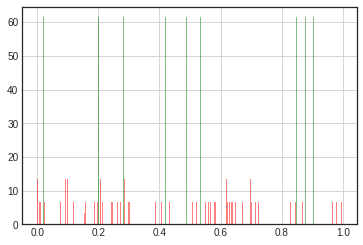

In [ ]:
n, bins, patches = plt.hist(df.loc[df["Within-Category"]==1, "Pear. Corr"], label="Same", color="green", alpha=0.5, bins=1000, density=True)
n, bins, patches = plt.hist(df.loc[df["Within-Category"]==0, "Pear. Corr"], label="Same", color="red", alpha=0.5, bins=1000, density=True)
plt.grid()

In [ ]:
df.groupby(["Within-Category"])["Norm", "Spear. Corr", "Pear. Corr"].std()

,Norm,Spear. Corr,Pear. Corr
Within-Category,,,
0,1.957360,0.313872,0.296037
1,1.904952,0.383465,0.305665


In [ ]:
df.groupby(["Within-Category", "Failure Mode"]).mean()

Norm  Spear. Corr  Pear. Corr
Within-Category Failure Mode                                   
0               AR            2.149814     0.310404    0.368531
                NR            3.059415     0.424270    0.440974
1               AR            1.595390     0.476502    0.356281
                NR            2.568057     0.525543    0.519098

In [ ]:
 df.groupby(["Within-Category"]){'Norm':['mean','std']

## Analyse rankings over datasets

In [ ]:
def get_ranking_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types, include_std: bool = True):

    # Collect the data.
    means_mnist = {}
    means_fmnist = {}
    means_cmnist = {}
    
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):

        means_mnist[estimator_category] = {}
        means_fmnist[estimator_category] = {}
        means_cmnist[estimator_category] = {}

        for px, perturbation_type in enumerate(perturbation_types):
            means_mnist[estimator_category][perturbation_type] = {}
            means_fmnist[estimator_category][perturbation_type] = {}
            means_cmnist[estimator_category][perturbation_type] = {}

            for ex2, estimator_name in enumerate(metrics):

                mnist_mean = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_means"]
                mnist_std = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]

                if include_std:
                    values = np.array([[m+2*mnist_std for m in mnist_mean], [m-2*mnist_std for m in mnist_mean]]).flatten()
                else: 
                    values = mnist_mean
                means_mnist[estimator_category][perturbation_type][estimator_name] = values

                fmnist_mean = benchmark_fmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_means"]
                fmnist_std = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]

                if include_std:
                    values = np.array([[m+2*fmnist_std for m in fmnist_mean], [m-2*fmnist_std for m in fmnist_mean]]).flatten()
                else: 
                    values = fmnist_mean
                means_fmnist[estimator_category][perturbation_type][estimator_name] = np.array([[m+2*fmnist_std for m in fmnist_mean], [m-2*fmnist_std for m in fmnist_mean]]).flatten()

                cmnist_mean = benchmark_cmnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_means"]
                cmnist_std = benchmark_mnist[estimator_category][estimator_name]["results_meta_consistency_scores"][perturbation_type]["MC_std"]

                if include_std:
                    values = np.array([[m+2*cmnist_std for m in cmnist_mean], [m-2*cmnist_std for m in cmnist_mean]]).flatten()
                else: 
                    values = cmnist_mean
                means_cmnist[estimator_category][perturbation_type][estimator_name] = values

    return means_mnist, means_fmnist, means_mnist


def compute_ranking(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Input", "Model"]):
    ranking = {}
    y1 = []
    y2 = []
    for estimator_category in estimators:
        ranking[estimator_category] = {}
        for perturbation_type in perturbation_types:   
            ranking[estimator_category][perturbation_type] = {}
            
            for means_ds, dataset_name in zip([means_mnist, means_fmnist, means_cmnist], ["MNIST", "fMNIST", "cMNIST"]):
                ranking[estimator_category][perturbation_type][dataset_name] = {}
                estimator_names = list(means_ds[estimator_category][perturbation_type].keys())
                estimator_name_1, estimator_name_2 = estimator_names[0], estimator_names[1]
                values = np.array(list(means_ds[estimator_category][perturbation_type].values()))
                results_estimator_1, results_estimator_2 = values[0], values[1]

                rank_data = np.argsort(values.flatten(), axis=0)
                rank_first = ((rank_data.max()+1)/2)
                estimator_1_first = 0
                for i in rank_data[:int(rank_first)]:
                    if i > rank_first:
                        #print(i, rank_first)
                        estimator_1_first += 1
                #print(rank_data, estimator_1_first)

                ranking[estimator_category][perturbation_type][dataset_name]["1st_estimator_first"] = estimator_1_first/rank_first
                ranking[estimator_category][perturbation_type][dataset_name]["2st_estimator_first"] = 1-(estimator_1_first/rank_first)
                #estimator_1_first = 0
                #estimator_1_first = rank_data[:6].sum()
                y1.append(estimator_1_first/rank_first)
                y2.append(1-(estimator_1_first/rank_first))

    print(rank_first)
    return ranking, y1, y2

In [ ]:
def plot_ranking(y1, y2, nr_tests=2, dataset_name: str = ""):

    if nr_tests == 2:
        fig, ax = plt.subplots(figsize=(12,5))
    else:
        fig, ax = plt.subplots(figsize=(8,5))

    datasets = ["MNIST", "fMNIST", "cMNIST"]
    nr_datasets = 3
    total_rankings = np.arange(len(estimators)*nr_tests*nr_datasets).astype(int)

    barlist1=plt.bar(total_rankings, y1, color=np.repeat(list(colours.values())[::2], repeats=nr_datasets*nr_tests), alpha=0.75, label="Estimator1", edgecolor="black")
    #colours = np.repeat(a="blue", repeats=len(total_rankings))
    #colours[5] = "green"
    barlist2=plt.bar(total_rankings, y2, bottom=y1, color=np.repeat(list(colours.values())[1::2], repeats=nr_datasets*nr_tests), alpha=0.5, label="Estimator2", edgecolor="black")

    #ax.bar_label(barlist1, fmt='%.3f', label_type='center', fontsize=18)
    #ax.bar_label(barlist2, fmt='%.3f', label_type='center', fontsize=18)

    #ax.set_yticks([])
    if nr_tests == 2:
        ax.set_xticks(ticks=np.arange(0, len(total_rankings)), labels=np.tile(["", "$\mathbf{IPT}$", "", "", "$\mathbf{MPT}$", ""], len(estimators)), fontsize=15)
    else:
        ax.set_xticks([], [])
    ax.legend(ncol=4, fontsize=20) # loc=2,

    
    #plt.xlabel(" ", fontsize=20)
    #plt.ylabel(" ", fontsize=20)
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="/"), 
                        matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="*"),
                        matplotlib.patches.Patch(facecolor='white', edgecolor='black'),]
        
    for i in range(0, len(total_rankings), 3):
        barlist1[i].set_hatch('/')
        barlist2[i].set_hatch('/')
    for i in range(1, len(total_rankings), 3):
        barlist1[i].set_hatch('*')
        barlist2[i].set_hatch('*')
    #for i in range(len(total_rankings)):
    #    barlist2[i].set_color(colours_repeat[i])

    plt.ylim(-0.05, 1.2)
    plt.yticks(ticks=np.linspace(0.0, 1.0, 20), labels=["", "", "", "", "30%", "", "", "", "", "50%", "", "", "", "70%", "", "", "", "90%", "", ""], fontsize=15)
    plt.legend(handles=legend_elements, labels=datasets, ncol=3, fontsize=15, loc="upper left") # loc=2,
    plt.ylabel("% Top Rank", fontsize=20)
    
    if nr_tests == 1:
        plt.xlabel("Complexity    Faithfulness    Localisation    Randomisation   Robustness", fontsize=13)
    
    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"ranking_{dataset_name}.png", dpi=1000)
    plt.show()

In [ ]:
# mörk, ljust, mörk, mörk, ljus

3.0


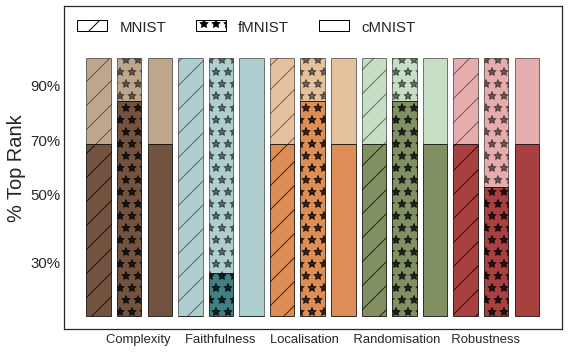

In [ ]:
means_mnist, means_fmnist, means_cmnist = get_ranking_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model"], include_std=False)
ranking, y1, y2 = compute_ranking(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Model"])
plot_ranking(y1, y2, nr_tests=1, dataset_name="ALL")
#ranking

In [ ]:
means_mnist, means_fmnist, means_cmnist = get_ranking_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Input", "Model"], include_std=True)
ranking, y1, y2 = compute_ranking(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Input", "Model"])


6.0


Text(0, 0.5, 'Estimator 2 wins')

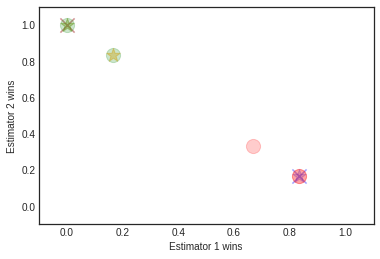

In [ ]:
for y11, y22, c, m in zip(y1, y2, np.repeat(list(colours_categories.values()), 3), np.repeat(["x", "*", "o"], 5).tolist()):
    #plt.plot(x, y + i*10, marker=markers[i], linestyle=lines[i], color=colors[i])
    plt.scatter(x=y11, y=y22, color=c, marker=m, s=200, alpha=0.2)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.xlabel("Estimator 1 wins")
plt.ylabel("Estimator 2 wins")

6.0


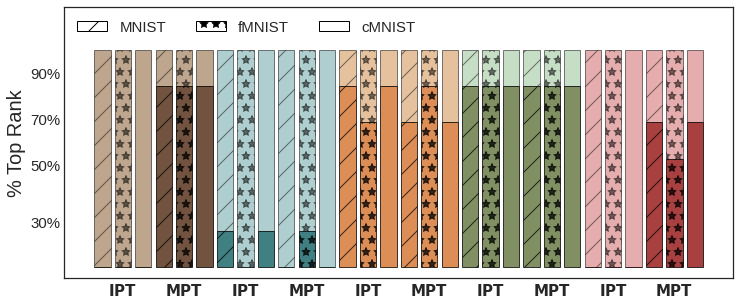

In [ ]:
means_mnist, means_fmnist, means_cmnist = get_ranking_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Input", "Model"], include_std=True)
ranking, y1, y2 = compute_ranking(means_mnist, means_fmnist, means_cmnist, estimators, perturbation_types=["Input", "Model"])
plot_ranking(y1, y2)
#ranking

## Analyse L dependency

In [ ]:
# Get benchmarking data.
path = Path(path_results+"l_dependency/")
#dataset_name = "MNIST"
files = sorted([str(f.stem) for f in list(path.iterdir())])
# if "11122022" in str(f.stem) and "LD" in str(f.stem)
# and "_"+dataset_name in str(f.stem)])
files, len(files), len([f for f in files if "_MNIST" in f]), len([f for f in files if "_fMNIST" in f]), len([f for f in files if "_cMNIST" in f])

(['15122022_MNIST_benchmark_exercise_4935_4_GR_SA_IX_GC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '15122022_cMNIST_benchmark_exercise_0c77_4_GR_SA_IX_GC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '15122022_cMNIST_benchmark_exercise_38db_4_GR_SA_OC_GC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '15122022_fMNIST_benchmark_exercise_b76d_4_GR_SA_IX_GC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '15122022_fMNIST_benchmark_exercise_d478_4_GR_SA_OC_GC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '16122022_MNIST_benchmark_exercise_5e28_2_GR_OC_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '16122022_MNIST_benchmark_exercise_6286_3_GR_SA_IG_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '16122022_MNIST_benchmark_exercise_8ee8_3_GR_GC_GS_Localisation_Complexity_Randomisation_Robustness_Faithfulness',
  '16122022_MNIST_benchmark_exercise_9132_2_GR_I

In [ ]:
def fix_name(name: str):
    if "Localisation" in name:
        name = name.split("Localisation")[0]# + "_Loc_Com_Ran"
    #elif  "Robustness" in name:
    #    name = name.split("Robustness")[0]# + "_Rob_Fai"
    if name.endswith("_"):
        name = name[:-1]
    return name

def load_source(files: list, dataset_name, model_name):
    
    print()
    print(dataset_name)
    print()
    
    benchmarks = {}
    for fname in files:
        if "_"+dataset_name in fname: #and ("15122022" in fname or "14122022" in fname):
            try:
                for i in ["_2_", "_3_", "_4_"]:
                    try:
                        name = i[1:] + fname.split(i)[1] 
                        name = fix_name(name=name)
                        if name not in benchmarks:

                            benchmarks[name] = load_obj(path_results+"l_dependency/", fname=fname, use_json=True)[dataset_name][model_name]
                            
                            # Update namings.
                            if name == "4_GR_SA_IX_GC":
                                benchmarks["4_GR_SA_IX_IG"] = benchmarks.pop(name)
                            if name == "4_GR_SA_OC_LR":
                                benchmarks["4_GR_SA_OC_GC"] = benchmarks.pop(name)    
                    except:
                        pass
                    
                #benchmarks[name] = load_obj(path_results+"L_dependency/", fname=fname, use_json=True)[dataset_name][model_name]
            except:
                pass #print(f"Could not load fname={fname}")
    
    for k in benchmarks:
        print(k)

    return benchmarks

benchmarks_mnist = load_source(files=files, dataset_name="MNIST", model_name="LeNet")#, benchmarks=benchmarks)
benchmarks_fmnist = load_source(files=files, dataset_name="fMNIST", model_name="LeNet")#, benchmarks=benchmarks)
benchmarks_cmnist = load_source(files=files, dataset_name="cMNIST", model_name="ResNet9")#, benchmarks=benchmarks)
#benchmarks = load_source(dataset_name="ImageNet", model_name="ResNet18", benchmarks=benchmarks)
len(benchmarks_mnist), len(benchmarks_fmnist), len(benchmarks_cmnist)


MNIST

4_GR_SA_IX_IG
2_GR_OC
3_GR_SA_IG
3_GR_GC_GS
2_GR_IX
4_GR_SA_OC_GC
2_GR_IG
2_GR_SA

fMNIST

4_GR_SA_IX_IG
4_GR_SA_OC_GC
3_GR_GC_GS
2_GR_SA
3_GR_SA_IG
2_GR_IX
2_GR_OC
2_GR_IG

cMNIST

4_GR_SA_OC_GC
2_GR_OC
2_GR_IG
2_GR_SA
3_GR_GC_GS
2_GR_IX
3_GR_SA_IG
4_GR_SA_IX_IG


(8, 8, 8)

In [ ]:
def get_scores(benchmark: dict, estimator_category: str, estimator_name: str, perturbation_type: str):
    try:
        scores = {
            "IAC_NR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_res"]).flatten(),
            "IAC_AR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["intra_scores_adv"]).flatten(),
            "IEC_NR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_res"]).flatten(),
            "IEC_AR" : np.array(benchmark[estimator_category][estimator_name]["results_consistency_scores"][perturbation_type]["inter_scores_adv"]).flatten(),
        }
        mc_scores = [np.mean(scores["IAC_NR"]), np.mean(scores["IAC_AR"]), np.mean(scores["IEC_NR"]), np.mean(scores["IEC_AR"])]
        #mc = np.mean(np.hstack(list(scores.values()))) #print(np.shape(values), values.size, values.ndim) #mc = np.mean(values)
        #print(np.hstack(list(scores.values())).size)
        #print(mc_scores)
        return scores, np.mean(mc_scores)
    except:

        raise KeyError(f"Could not find data for estimator={estimator_name}.")

def print_standard_deviations_per_benchmarks(dataset_name: str, benchmarks: dict, estimators: dict):

    print(dataset_name)
    print()
    mc_scores = {}
    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            mc_scores[estimator_name] = {}
            for px, perturbation_type in enumerate(["Input", "Model"]):
                mc_scores[perturbation_type] = {}
                mcs = []
                all_scores = {"IAC_NR": list(), "IAC_AR": list(), "IEC_NR": list(), "IEC_AR": list(),}
                scores = {}
                explanation_sets = []
                for explanation_set, benchmark in benchmarks.items():
                    try:
                        explanation_sets.append(explanation_set)
                        scores, mc = get_scores(benchmark, estimator_category, estimator_name, perturbation_type)
                        mcs.append(mc)
                        #print(f"{estimator_name} {mc} {perturbation_type}")
                        for criterion, values in scores.items():
                            all_scores[criterion].append(np.array(values))
                    except:
                        continue
                if perturbation_type == "Input":
                    perturbation_name = "IPT"
                elif perturbation_type == "Model":
                    perturbation_name = "MPT"
                    
                if len(mcs) > 1:
                    print(f"{estimator_name} mean={np.mean(mcs):.2f} std=({np.std(mcs):.4f}) Test={perturbation_name} Combinations={len(mcs)}")

                    #for criterion, values in all_scores.items():
                    #    s = np.hstack(values)
                    #    print(f"\t{criterion}: mean={np.mean(s):.3f}, std={np.std(s):.3f}")
                    
                mc_scores[estimator_name][perturbation_type] = mcs

    # Clean up.
    explanation_sets = [e.split("Loc_Com_Ran")[0] if "Loc_Com_Ran" in e else e for e in explanation_sets]
    explanation_sets = [e.split("_Rob_Fai")[0] if "Rob_Fai" in e else e for e in explanation_sets]
    
    print("\nFull list of tested combinations:\n")
    for ex, explanation_set in enumerate(np.unique(explanation_sets)):
        print(f"\t{ex+1}. {explanation_set}")

    print() 

    return mc_scores

In [ ]:
mc_scores_mnist = print_standard_deviations_per_benchmarks(dataset_name="MNIST", benchmarks=benchmarks_mnist, estimators=estimators)
mc_scores_fmnist = print_standard_deviations_per_benchmarks(dataset_name="fMNIST", benchmarks=benchmarks_fmnist, estimators=estimators)
mc_scores_cmnist = print_standard_deviations_per_benchmarks(dataset_name="cMNIST", benchmarks=benchmarks_cmnist, estimators=estimators)

MNIST

Sparseness mean=0.51 std=(0.0131) Test=IPT Combinations=8
Sparseness mean=0.69 std=(0.0126) Test=MPT Combinations=8
Complexity mean=0.50 std=(0.0000) Test=IPT Combinations=8
Complexity mean=0.54 std=(0.0439) Test=MPT Combinations=8
Faithfulness Correlation mean=0.64 std=(0.0588) Test=IPT Combinations=8
Faithfulness Correlation mean=0.61 std=(0.0532) Test=MPT Combinations=8
Pixel-Flipping mean=0.72 std=(0.0359) Test=IPT Combinations=8
Pixel-Flipping mean=0.69 std=(0.0424) Test=MPT Combinations=8
Pointing-Game mean=0.50 std=(0.0000) Test=IPT Combinations=8
Pointing-Game mean=0.69 std=(0.0609) Test=MPT Combinations=8
Relevance Mass Accuracy mean=0.50 std=(0.0066) Test=IPT Combinations=8
Relevance Mass Accuracy mean=0.65 std=(0.0349) Test=MPT Combinations=8
Random Logit mean=0.65 std=(0.0316) Test=IPT Combinations=8
Random Logit mean=0.71 std=(0.0096) Test=MPT Combinations=8
Model Parameter Randomisation Test mean=0.61 std=(0.0290) Test=IPT Combinations=8
Model Parameter Randomisati

In [ ]:
def get_mc_scores_data_over_datasets(mc_scores_mnist, mc_scores_fmnist, mc_scores_cmnist, estimators, perturbation_types):

    # Collect the data.
    mnist_means = []
    mnist_stds = []
    fmnist_means = []
    fmnist_stds = []
    cmnist_means = []
    cmnist_stds = []

    for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
        for ex2, estimator_name in enumerate(metrics):
            mnist_means_per = []
            mnist_stds_per = []
            fmnist_means_per = []
            fmnist_stds_per = []
            cmnist_means_per = []
            cmnist_stds_per = []

            for px, perturbation_type in enumerate(perturbation_types):
                print(estimator_category, estimator_name)
                
                mnist_mean = np.mean(mc_scores_mnist[estimator_name][perturbation_type])
                mnist_std = np.std(mc_scores_mnist[estimator_name][perturbation_type])
                mnist_means_per.append(mnist_mean)
                mnist_stds_per.append(mnist_std)

                fmnist_mean = np.mean(mc_scores_fmnist[estimator_name][perturbation_type])
                fmnist_std = np.std(mc_scores_fmnist[estimator_name][perturbation_type])
                fmnist_means_per.append(fmnist_mean)
                fmnist_stds_per.append(fmnist_std)

                cmnist_mean = np.mean(mc_scores_cmnist[estimator_name][perturbation_type])
                cmnist_std = np.std(mc_scores_cmnist[estimator_name][perturbation_type])
                cmnist_means_per.append(cmnist_mean)
                cmnist_stds_per.append(cmnist_std)
            
            mnist_means.append(np.mean(mnist_means_per))
            mnist_stds.append(np.mean(mnist_stds_per))
            fmnist_means.append(np.mean(fmnist_means_per))
            fmnist_stds.append(np.mean(fmnist_stds_per))
            cmnist_means.append(np.mean(cmnist_means_per))
            cmnist_stds.append(np.mean(cmnist_stds_per))
            

    means = np.array([[a, b, c] for a, b, c in zip(mnist_means, fmnist_means, cmnist_means)]).flatten()
    stds = np.array([[a, b, c] for a, b, c in zip(mnist_stds, fmnist_stds, cmnist_stds)]).flatten()

    return means, stds

In [ ]:
def plot_mc_scores_over_datasets(means: list, stds: list, dataset_name: str):

    # MNIST, fMNIST, cMNIST
    datasets = ["MNIST", "fMNIST", "cMNIST"]
    nr_datasets = 3

    metrics_short = ["SP", "CO", "FC", "PF", "PG", "RMA", "RL", "MPR", "MS", "LLE"]
    colours_repeat = np.repeat(list(colours.values()), repeats=nr_datasets)
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="/"), 
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="*"),
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black'),]

    x = [ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 38]
    labels_ticks = list(range(1, np.max(x)+1, nr_datasets+1))
    labels_ticks[0] = 1.5

    # Insert real data.
    #means=np.random.random(size=len(metrics)*nr_datasets)
    #s=np.random.uniform(0, 0.1, len(metrics)*nr_datasets)

    fig, ax = plt.subplots(figsize=(20, 4))
    barlist=ax.bar(x, means, yerr=stds, alpha=0.85)

    # Alt 1.
    plt.bar_label(barlist, fmt='%.2f', label_type='edge', fontsize=15)

    for i in range(0, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('/')
    for i in range(1, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('*')
    for i in range(len(metrics_short)*nr_datasets):
        barlist[i].set_color(colours_repeat[i])

    ax.set_xticks(ticks=labels_ticks, labels=metrics_short, fontsize=20)#, rotation=90)
    plt.grid()
    plt.ylabel("MC", fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylim(np.min(means)-0.1, np.max(means)+0.05)
    plt.yticks(ticks=np.linspace(0.5, 0.9, 8), labels=[0.5, "", 0.6, "", 0.7, "", 0.8, ""], fontsize=15)
    ax.legend(handles=legend_elements, labels=datasets, ncol=3, fontsize=15, loc="upper left") # loc=2,

    plt.tight_layout()
    plt.savefig(path_results+"plots/"+f"mc_scores_{dataset_name}.png", dpi=1000)
    plt.show()


Complexity Sparseness
Complexity Sparseness
Complexity Complexity
Complexity Complexity
Faithfulness Faithfulness Correlation
Faithfulness Faithfulness Correlation
Faithfulness Pixel-Flipping
Faithfulness Pixel-Flipping
Localisation Pointing-Game
Localisation Pointing-Game
Localisation Relevance Mass Accuracy
Localisation Relevance Mass Accuracy
Randomisation Random Logit
Randomisation Random Logit
Randomisation Model Parameter Randomisation Test
Randomisation Model Parameter Randomisation Test
Robustness Max-Sensitivity
Robustness Max-Sensitivity
Robustness Local Lipschitz Estimate
Robustness Local Lipschitz Estimate


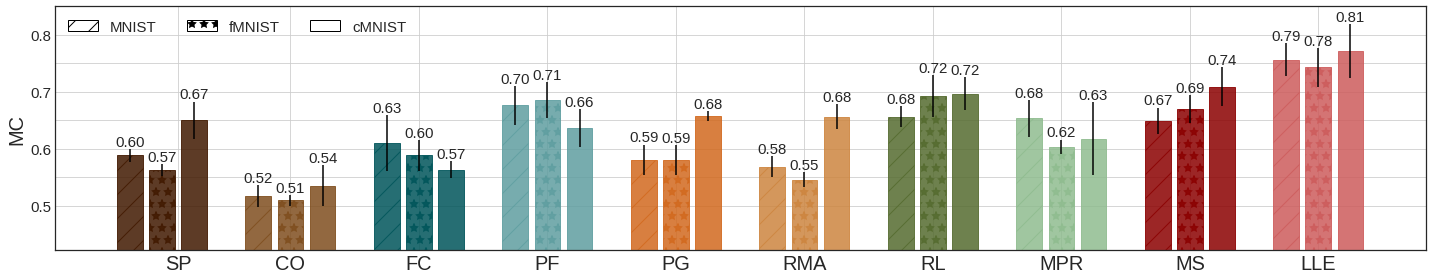

In [ ]:
means, stds = get_mc_scores_data_over_datasets(mc_scores_mnist, mc_scores_fmnist, mc_scores_cmnist, estimators, perturbation_types=["Input", "Model"])
plot_mc_scores_over_datasets(means=means, stds=stds, dataset_name="ALL")

In [ ]:
for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
    for ex2, estimator_name in enumerate(metrics):
        for px, perturbation_type in enumerate(["Input", "Model"]):
            for explanation_set, benchmark in benchmarks_mnist.items():
                try:
                    name = fix_name(name=explanation_set)
                    fig, _ = plot_single_estimator_area(benchmark, estimator_category, estimator_name, perturbation_type, title=name)
                except:
                    pass
        

Output hidden; open in https://colab.research.google.com to view.

## Analyse benchmarks over datasets

In [ ]:
benchmark_mnist["Complexity"]["Sparseness"].keys()

dict_keys(['results_intra_scores', 'results_inter_scores', 'results_eval_scores', 'results_eval_scores_perturbed', 'results_indices_perturbed', 'results_meta_consistency_scores', 'results_consistency_scores'])

In [ ]:
def plot_benchmarks_over_datasets(means, stds):

    # MNIST, fMNIST, cMNIST
    datasets = ["MNIST", "fMNIST", "cMNIST"]
    nr_datasets = 3

    metrics_short = ["SP", "CO", "FC", "PF", "PG", "RMA", "RL", "MPR", "MS", "LLE"]
    colours_repeat = np.repeat(list(colours.values()), repeats=nr_datasets)
    legend_elements = [matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="/"), 
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black', hatch="*"),
                    matplotlib.patches.Patch(facecolor='white', edgecolor='black'),]

    x = [ 0,  1,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 26, 28, 29, 30, 32, 33, 34, 36, 37, 38]
    labels_ticks = list(range(1, np.max(x)+1, nr_datasets+1))
    labels_ticks[0] = 1.5

    # Insert real data.
    #means=np.random.random(size=len(metrics)*nr_datasets)
    #s=np.random.uniform(0, 0.1, len(metrics)*nr_datasets)

    fig, ax = plt.subplots(figsize=(8,5))
    barlist=ax.bar(x, means, yerr=stds, alpha=0.85)

    ax.bar_label(barlist, fmt='%.2f', label_type='edge', fontsize=15)

    for i in range(0, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('/')
    for i in range(1, len(metrics_short)*nr_datasets, 3):
        barlist[i].set_hatch('*')
    for i in range(len(metrics_short)*nr_datasets):
        barlist[i].set_color(colours_repeat[i])

    ax.set_xticks(ticks=labels_ticks, labels=metrics_short, fontsize=20)#, rotation=90)
    plt.ylabel("$\mathbf{MC}$", fontsize=20)
    plt.yticks(fontsize=15)
    plt.ylim(np.min(means)-0.1, np.max(means)+0.1)
    ax.legend(handles=legend_elements, labels=datasets, ncol=3, fontsize=15) # loc=2,
    plt.show()


#### Input dependency

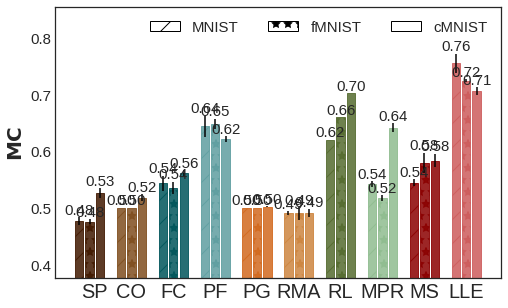

In [ ]:
means, stds = get_benchmark_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Input"])
plot_benchmarks_over_datasets(means, stds)

#### Model dependency

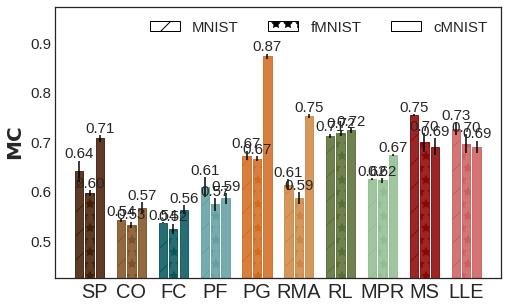

In [ ]:
means, stds = get_benchmark_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model"])
plot_benchmarks_over_datasets(means, stds)

#### Both input and model


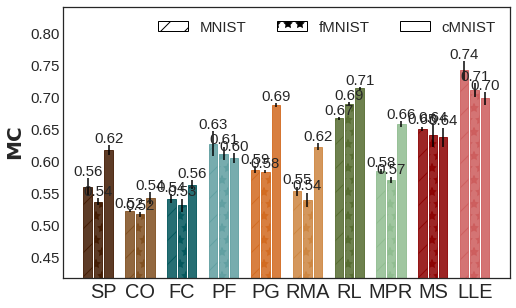

In [ ]:
means, stds = get_benchmark_data_over_datasets(benchmark_mnist, benchmark_fmnist, benchmark_cmnist, estimators, perturbation_types=["Model", "Input"])
plot_benchmarks_over_datasets(means, stds)

## Analyse sanity checks

In [ ]:
# Get benchmarking data.
path = Path(path_results+"sanity_checks/")    
[str(f.stem) for f in list(path.iterdir())]

['24112022_Complement_NR_eval_scores_perturbed_ed25',
 '24112022_Complement_NR_eval_scores_ed25',
 '24112022_Complement_NR_indices_perturbed_ed25',
 '24112022_Complement_NR_intra_scores_ed25',
 '24112022_Complement_NR_inter_scores_ed25',
 '24112022_Complement_NR_indices_correct_ed25',
 '24112022_Complement_AR_eval_scores_5bdc',
 '24112022_Complement_AR_eval_scores_perturbed_5bdc',
 '24112022_Complement_AR_indices_perturbed_5bdc',
 '24112022_Complement_AR_indices_correct_5bdc',
 '24112022_Complement_AR_intra_scores_5bdc',
 '24112022_Complement_AR_inter_scores_5bdc',
 '24112022_Complement_NR_eval_scores_b9fb',
 '24112022_Complement_NR_intra_scores_b9fb',
 '24112022_Complement_NR_inter_scores_b9fb',
 '24112022_Complement_AR_eval_scores_perturbed_36c6',
 '24112022_Complement_AR_eval_scores_36c6',
 '24112022_Complement_AR_indices_perturbed_36c6',
 '24112022_Complement_AR_intra_scores_36c6',
 '24112022_Complement_AR_indices_correct_36c6',
 '24112022_Complement_AR_inter_scores_36c6',
 '241120

In [ ]:
today = "01122022"
uid_nr = "187a"
uid_ar = "62a3"
iters = 3
K = 5

def print_mean_std(score_type: str, expectation: str, scores: np.array):
    if "IAC" in score_type:
        score_means = scores.mean(axis=(0, 2))
    else:
        score_means = scores.mean(axis=1)
    print(f"\t{score_type}={score_means.mean():.4f} ({score_means.std():.3f}) \t-----\tExpectation{expectation}")


for perturbation_type in  ["Input", "Model"]:

    print(
        f"\nControlled scenario 1: the estimator always returns the same score, independent of perturbation (deterministic sampling). uid={uid_ar}\n")
    print(f"{perturbation_type} Perturbation Test")

    inter_scores_nr = np.array(
        load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Same_inter_scores_{uid_ar}", use_json=True)[
            f"{perturbation_type} Resilience Test"]).reshape(iters, K)
    intra_scores_nr = load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Same_intra_scores_{uid_ar}",
                                use_json=True)
    intra_scores_nr = np.array(list(intra_scores_nr[f"{perturbation_type} Resilience Test"].values())).reshape(
        len(xai_methods), iters, K)
    inter_scores_ar = np.array(
        load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Same_inter_scores_{uid_ar}", use_json=True)[
            f"{perturbation_type} Adversary Test"]).reshape(iters, K)
    intra_scores_ar = load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Same_intra_scores_{uid_ar}",
                                use_json=True)
    intra_scores_ar = np.array(list(intra_scores_ar[f"{perturbation_type} Adversary Test"].values())).reshape(
        len(xai_methods), iters, K)

    print_mean_std(score_type="IAC_{NR}", expectation="=1.0 (should succeed: scores are the same!)",
                    scores=intra_scores_nr)
    print_mean_std(score_type="IAC_{AR}", expectation="=0.0 (should fail: scores are not different!)",
                    scores=intra_scores_ar)
    print_mean_std(score_type="IEC_{NR}", expectation="=1.0 (should succed: scores, then rankings are the same!)",
                    scores=inter_scores_nr)
    print_mean_std(score_type="IEC_{AR}",
                    expectation="=0.0 (should fail: does not fulfil ranking condition '<' since '=')",
                    scores=inter_scores_ar)

    
    print(
        f"\nControlled scenario 2: the estimator always returns scores from a different distribution (stochastic sampling). uid={uid_nr}\n")
    print(f"{perturbation_type} Perturbation Test")

    inter_scores_nr = np.array(
        load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Different_inter_scores_{uid_nr}", use_json=True)[
            f"{perturbation_type} Resilience Test"]).reshape(iters, K)
    intra_scores_nr = load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Different_intra_scores_{uid_nr}",
                                use_json=True)
    intra_scores_nr = np.array(list(intra_scores_nr[f"{perturbation_type} Resilience Test"].values())).reshape(
        len(xai_methods), iters, K)
    inter_scores_ar = np.array(
        load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Different_inter_scores_{uid_nr}", use_json=True)[
            f"{perturbation_type} Adversary Test"]).reshape(iters, K)
    intra_scores_ar = load_obj(path_results + "sanity_checks/", fname=f"{today}_Estimator_Different_intra_scores_{uid_nr}",
                                use_json=True)
    intra_scores_ar = np.array(list(intra_scores_ar[f"{perturbation_type} Adversary Test"].values())).reshape(
        len(xai_methods), iters, K)

    print_mean_std(score_type="IAC_{NR}", expectation="≈0.0 (should fail: scores are different!)", scores=intra_scores_nr)
    print_mean_std(score_type="IAC_{AR}", expectation="≈1.0 (should succeed: scores are different!)",
                    scores=intra_scores_ar)
    print_mean_std(score_type="IEC_{NR}",
                    expectation="≈0.25 (should be =1/L, where L=4: no diff in scores between explainers)",
                    scores=inter_scores_nr)
    print_mean_std(score_type="IEC_{AR}", expectation="≈0.0 (depends on the sampling distributions and its variation!)",
    scores=inter_scores_ar)
    


Controlled scenario 1: the estimator always returns the same score, independent of perturbation (deterministic sampling). uid=62a3

Input Perturbation Test
	IAC_{NR}=1.0000 (0.000) 	-----	Expectation=1.0 (should succeed: scores are the same!)
	IAC_{AR}=0.0000 (0.000) 	-----	Expectation=0.0 (should fail: scores are not different!)
	IEC_{NR}=1.0000 (0.000) 	-----	Expectation=1.0 (should succed: scores, then rankings are the same!)
	IEC_{AR}=0.0000 (0.000) 	-----	Expectation=0.0 (should fail: does not fulfil ranking condition '<' since '=')

Controlled scenario 2: the estimator always returns scores from a different distribution (stochastic sampling). uid=187a

Input Perturbation Test
	IAC_{NR}=0.0000 (0.000) 	-----	Expectation≈0.0 (should fail: scores are different!)
	IAC_{AR}=1.0000 (0.000) 	-----	Expectation≈1.0 (should succeed: scores are different!)
	IEC_{NR}=0.2480 (0.004) 	-----	Expectation≈0.25 (should be =1/L, where L=4: no diff in scores between explainers)
	IEC_{AR}=0.0000 (0.

## Redundant

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

nr_settings = 12
nr_scores = 5

dummy_scores = np.array([np.random.random(size=nr_scores) for _ in range(nr_settings)])

fig, ax = plt.subplots(figsize=(10, 6))
for setting_id, setting in enumerate(dummy_scores):
    plt.plot(setting, label=setting_id)
plt.legend()
ax.set_xticks(ticks=np.arange(0, nr_scores), labels=["$IAC_{NR}$", "$IAC_{AR}$", "$IEC_{NR}$", "$IEC_{AR}$", "$\matbf{MC}$"], fontsize=20)#, rotation=90)

In [ ]:
benchmark = benchmark_mnist 
plt.style.use(['seaborn-white'])
perturbation_type = "Input"

fig, axs = plt.subplots(2, 5, sharex=True, figsize=(20, 8)) #sharex=True, sharey=True, 


for ex1, (estimator_category, metrics) in enumerate(estimators.items()):
    for ex2, estimator_name in enumerate(metrics):

        intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
        intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
        inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
        inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])
        
        X_gt = [-1, 0, 1, 0]
        Y_gt = [0, 1, 0, -1]
        X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
        Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

        scores = np.array([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
        axs[ex2, ex1].fill(X_gt, Y_gt, color="black", alpha=0.1)
        #axs[ex2, ex1].fill(X_area, Y_area, color=list(cnames.values())[(ex1*20)+(ex2+1)], alpha=0.5)
        axs[ex2, ex1].fill(X_area, Y_area, color=colours[estimator_name], alpha=0.5)
        # Annotate.
        #axs[ex2, ex1].annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
        #axs[ex2, ex1].annotate("\n\n${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
        #axs[ex2, ex1].annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
        
        axs[ex2, ex1].annotate("${IAC}_{AR}$", (-1, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IAC}_{NR}$", (-0.2, 0.8), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{AR}$", (0.7, 0), fontsize=12)
        axs[ex2, ex1].annotate("${IEC}_{NR}$", (-0.2, -0.8), fontsize=12)
        
        # Labels.
        axs[ex2, ex1].set_xticklabels(["", "1", "0.5",  "0", "0.5", "1"], fontsize=14)
        
        axs[ex2, ex1].set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=14)
        if estimator_name == "Model Parameter Randomisation Test":
            estimator_name = "Model Parameter Randomisation"
        axs[ex2, ex1].set_title(f"{estimator_name} ({scores.mean():.2f})", fontsize=14)
        axs[ex2, ex1].grid()

        #axs[ex2, ex1].plot([0, 0], [-1, 1], '--bo', label='NR')
        #axs[ex2, ex1].plot([-1, 1], [0, 0], '--go', label='AR')

        # Limits.
        #axs[ex2, ex1].set_xlim(-1.6, 1.6)
        #axs[ex2, ex1].set_ylim(-1.6, 1.6)
        plt.grid()
            

In [ ]:
estimator_category = "Complexity"
estimator_name = "Sparseness" #
perturbation_type = "Model"

intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])

#sns.distplot(intra_scores_res, color="green", label="Resilience")
#sns.distplot(intra_scores_adv, color="red", label="Adversary")
#plt.show()

fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.set_facecolor("white")

print([intra_scores_res.mean(), inter_scores_res.mean(), intra_scores_adv.mean(), inter_scores_adv.mean()])
plt.fill([-1, -1, 1, -1], [-1, 1, -1, -1], color="black", alpha=0.25)
plt.fill([-1, -1, intra_scores_adv.mean(), inter_scores_adv.mean()], [-inter_scores_res.mean(), intra_scores_res.mean(), 0, -1], color="red", alpha=0.5)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axis('off');

### In general, which faithfulness/ complexity/ robustness/ randomisation/ localisation measure is the best?

In [ ]:
def get_quick_stats(estimator_category: str, tests: list, estimators: dict):
    for estimator_name in estimators[estimator_category]:
        print(f"{estimator_name}\t")
        for test in tests:
            if "Resilience" in test:
                arrow = "⬆"
            else:
                arrow = "⬇"
            print(f"\t{test}\t")
            print(f"\t\tIntra ({arrow}): {get_statistics_intra_scores(benchmark[estimator_category][estimator_name]['intra_scores'], test=test)}\n\t\t" \
            f"Inter (⬆): {get_statistics_inter_scores(benchmark[estimator_category][estimator_name]['inter_scores'], test=test)}")

In [ ]:
get_quick_stats(estimator_category="Faithfulness", tests=analyser_suite, estimators=estimators)

Faithfulness Correlation	
	Model Resilience Test	
		Intra (⬆): (0.43291534771913087, 0.26704790998120126)
		Inter (⬆): (0.29697265625, 0.007193826296192115)
	Input Resilience Test	
		Intra (⬆): (0.5134696717803475, 0.3294217667384682)
		Inter (⬆): (0.2925537109375, 0.013423760953302494)
	Model Adversary Test	
		Intra (⬇): (0.258304451677822, 0.33331090833387034)
		Inter (⬆): (0.5988094617767824, 0.0059963673019729396)
	Input Adversary Test	
		Intra (⬇): (0.18616201881813377, 0.2800438795438413)
		Inter (⬆): (0.6006090673901017, 0.00398534448926149)
Pixel-Flipping	
	Model Resilience Test	
		Intra (⬆): (0.5534743811997412, 0.3080313741150198)
		Inter (⬆): (0.427392578125, 0.004958158901362693)
	Input Resilience Test	
		Intra (⬆): (0.5010081657855457, 0.30762110217307315)
		Inter (⬆): (0.4307373046875, 0.006965542110533517)
	Model Adversary Test	
		Intra (⬇): (0.05642619206106788, 0.18292807112455406)
		Inter (⬆): (0.6251921255360707, 0.14689803503108495)
	Input Adversary Test	
		Intra (⬇

In [ ]:
get_quick_stats(estimator_category="Randomisation", tests=analyser_suite, estimators=estimators)

Random Logit	
	Model Resilience Test	
		Intra (⬆): (0.22609878445369452, 0.283488528448647)
		Inter (⬆): (0.99658203125, 0.0009518353852352503)
	Input Resilience Test	
		Intra (⬆): (0.21726307491146796, 0.2695215216882422)
		Inter (⬆): (0.906005859375, 0.0)
	Model Adversary Test	
		Intra (⬇): (0.005360552400390957, 0.01906657126639607)
		Inter (⬆): (0.4277243164777159, 0.050037262690806716)
	Input Adversary Test	
		Intra (⬇): (1.513748465780375e-06, 2.621884046999899e-06)
		Inter (⬆): (0.4557205720572057, 5.551115123125783e-17)
Model Parameter Randomisation Test	
	Model Resilience Test	
		Intra (⬆): (0.36804255263779484, 0.34320325898023096)
		Inter (⬆): (0.99365234375, 0.0)
	Input Resilience Test	
		Intra (⬆): (0.22964501354285938, 0.2857865450348358)
		Inter (⬆): (0.835498046875, 0.005267783065164212)
	Model Adversary Test	
		Intra (⬇): (0.019104903129628686, 0.0313243910925978)
		Inter (⬆): (0.44844789356984477, 0.0)
	Input Adversary Test	
		Intra (⬇): (0.21073275916181844, 0.261506

### Get all intra-scores over all XAI methods.

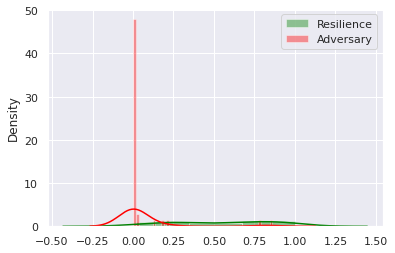

In [ ]:
estimator_category = "Faithfulness"
estimator_name = "Pixel-Flipping"
test = "Model Resilience Test"
intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][test].values())).flatten()
test = "Model Adversary Test"
intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][test].values())).flatten()

sns.distplot(intra_scores_res, color="green", label="Resilience")
sns.distplot(intra_scores_adv, color="red", label="Adversary")
plt.legend();

### Get all scores over one specific XAI method.

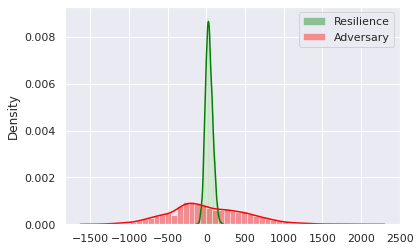

In [ ]:
iter = "1"
xai_method = "IntegratedGradients"
test = "Model Resilience Test"
eval_scores_perturbed_res = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][iter][xai_method]
test = "Model Adversary Test"
eval_scores_perturbed_adv = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][iter][xai_method]

sns.distplot(eval_scores_perturbed_res, color="green", label="Resilience")
sns.distplot(eval_scores_perturbed_adv, color="red", label="Adversary")
plt.legend();

### How does the score distribution change over different XAI methods?

In [ ]:
intra_scores

[[0.7926824644589086,
  0.24466799870445965,
  0.8660287796622268,
  0.6276106923688685,
  0.016661745769866947],
 [0.6655428307293754,
  0.34951232333494153,
  0.7517884445816739,
  0.014750140789962259,
  0.19725036442712607]]

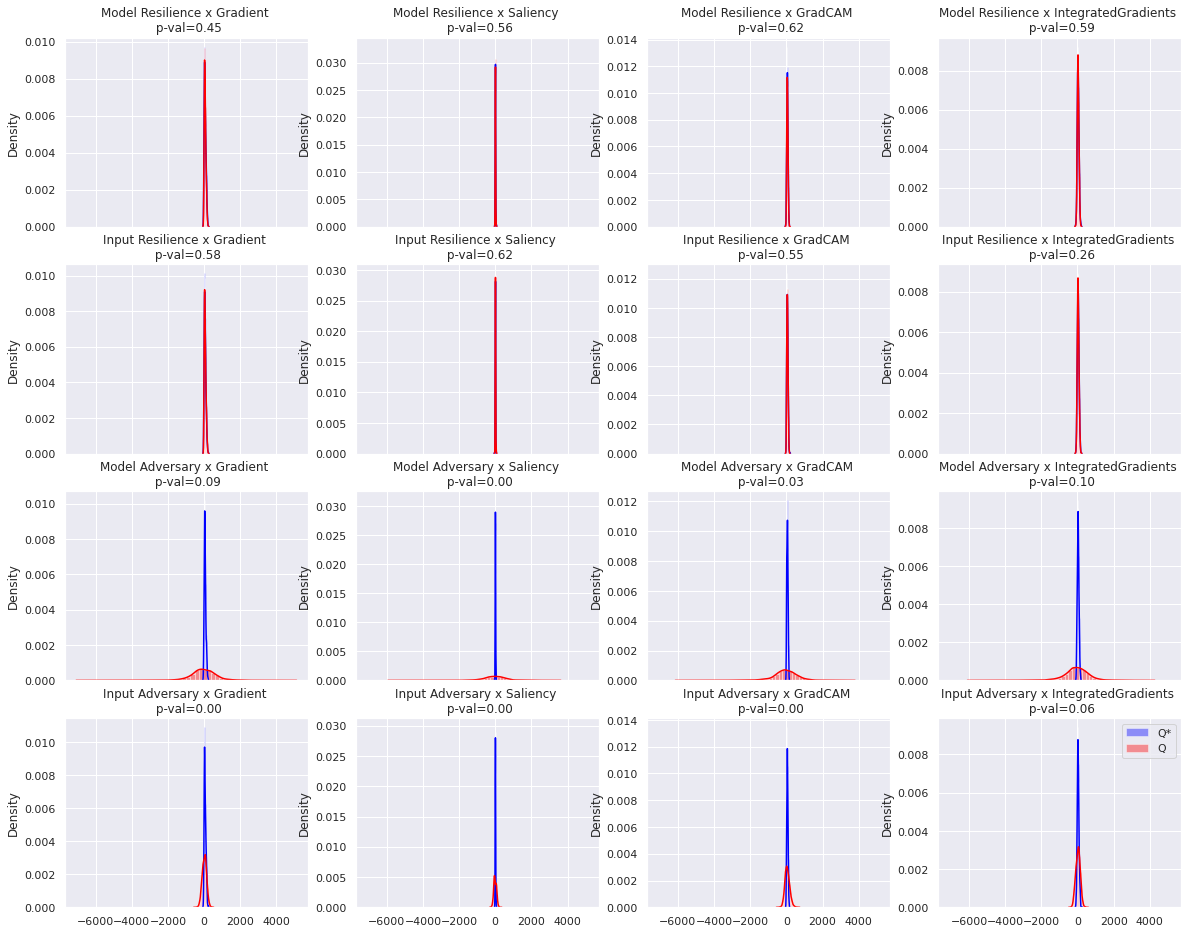

In [ ]:
test = "Model Adversary Test"

# Plot it!
fig, axs = plt.subplots(4, 4, sharex=True, figsize=(20, 16))
for ti, test in enumerate(analyser_suite):
    for xi, xai_method in enumerate(xai_methods):
        eval_scores = benchmark[estimator_category][estimator_name]["eval_scores"][test][xai_method]
        sns.distplot(eval_scores, color="blue", ax=axs[ti, xi], label="Q*")
        perturbed_scores=[]
        for iter in range(2):
            eval_scores_perturbed = benchmark[estimator_category][estimator_name]["eval_scores_perturbed"][test][str(iter)][xai_method]
            perturbed_scores.append(eval_scores_perturbed)
        sns.distplot(np.array(perturbed_scores).flatten(), color="red", ax=axs[ti, xi], label="Q")
        intra_scores = benchmark[estimator_category][estimator_name]["intra_scores"][test][xai_method]
        axs[ti, xi].set_title(f"{test.replace(' Test', '')} x {xai_method} \n p-val={np.mean(intra_scores):.2f}")
plt.legend()
plt.show()

In [ ]:
def plot_estimator_area(benchmark: dict,
                        estimator_category: str, 
                        estimator_name: str,
                        perturbation_type: str
                        ):
    
    intra_scores_res = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Resilience Test"].values())).flatten()
    intra_scores_adv = np.array(list(benchmark[estimator_category][estimator_name]["intra_scores"][f"{perturbation_type} Adversary Test"].values())).flatten()
    inter_scores_res = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Resilience Test"])
    inter_scores_adv = np.array(benchmark[estimator_category][estimator_name]['inter_scores'][f"{perturbation_type} Adversary Test"])

    fig = plt.figure(figsize=(5, 5))
    ax = plt.axes()
    plt.grid()

    X_gt = [-1, 0, 1, 0]
    Y_gt = [0, 1, 0, -1]
    X_area = [-intra_scores_adv.mean(), 0, inter_scores_adv.mean(), 0]
    Y_area = [0, intra_scores_res.mean(), 0, -inter_scores_res.mean()]

    #print([intra_scores_adv.mean(), inter_scores_adv.mean(), intra_scores_res.mean(), inter_scores_res.mean()])
    plt.fill(X_gt, Y_gt, color="black", alpha=0.1)
    plt.fill(X_area, Y_area, color="blue", alpha=0.25)

    # Annotate.
    plt.annotate("${IAC}_{AR}$"+f"={intra_scores_adv.mean():.2f}", (-intra_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IAC}_{NR}$"+f"={intra_scores_res.mean():.2f}", (-0.2, intra_scores_res.mean()+0.05), fontsize=12)
    plt.annotate("${IEC}_{AR}$"+f"={inter_scores_adv.mean():.2f}", (inter_scores_adv.mean(), 0.1), fontsize=12)
    plt.annotate("${IEC}_{NR}$"+f"={inter_scores_res.mean():.2f}", (-0.2, -inter_scores_res.mean()-0.1), fontsize=12)
    
    # Labels.
    ax.set_xticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    ax.set_yticklabels(["", "1", "", "0.5", "",  "0", "", "0.5", "", "1", ""], fontsize=15)
    plt.title(f"{estimator_name}", fontsize=20)
    
    # Limits.
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    return fig